**MSc Computational Physics AUTh**<br>
**Academic Year: 2024-2025**<br>
**Master's Thesis**<br>

**Thesis Title:**<br>  
# **"Reconstruction of the EoSs of Exotic Stars using ML and ANNs regression models"**

**Implemented by: Ioannis Stergakis**<br>
**AEM: 4439**<br>

**Jupyter Notebook: JN10**<br>
**Name: "reconstruct_EOS_QS.ipynb"**<br>

**Description:**<br> 
**Reconstructing EOSs of Quark Stars**


**Abbrevations:**<br>
**1. NS -> Neutron Star**<br>
**2. QS -> Quark Star**<br>
**3. ML -> Machine Learning**<br>
**4. DL -> Deep Learning**<br>
**5. DNN -> Deep Neural Network**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
from sklearn.metrics import mean_squared_log_error
from ExoticStarsDataHandling import *

# 1. Preliminaries

In [2]:
def predict_EOS_mitbagQS(axis_EOS,axis_MR,mitbag_EOS,reg_models_infos:np.ndarray,points_MR,Pc_points,iterations,include_Mmax=True):
    num_pcpoints = len(Pc_points)
    num,num_models= np.shape(reg_models_infos)

    print(f"> {mitbag_EOS}")
    filename = f"{mitbag_EOS}_sol.csv"
    EOS_data = pd.read_csv(filename)

    slope_values,enrg_values,pc_mmax,enrg_mmax = QSdata().sample_EOS(filename,Pc_points,violate_caus="both")
    
    Pc_data = EOS_data.iloc[:,1]
    Ec_data = EOS_data.iloc[:,2]
    M_data = EOS_data.iloc[:,4]
    R_data = EOS_data.iloc[:,5]

    data_columns = EOS_data.columns
    B_col = data_columns[-1]
    B_val = float(B_col[3:])
    
    M_points = np.zeros([iterations,points_MR])
    R_points = np.zeros([iterations,points_MR])

    Enrg_true = np.tile(enrg_values,(iterations,1))
    #print(Enrg_true)

    models_predictions = np.zeros([num_models,iterations,num_pcpoints])
    #print(models_predictions)

    msle_results = np.zeros((num_models,1))
    #print(msle_results)

    # Plotting
    QSdata().plot_EOS_curve(filename=filename,axis_EOS=axis_EOS,clr_caus="cornflowerblue",curve_label=f"{mitbag_EOS} ({B_val:.1f})")
    if include_Mmax:
        axis_EOS.plot(pc_mmax,enrg_mmax,"s",ms=7,color="black",label=r"$M_{max}$ pt. "+f"({pc_mmax:.1f},{enrg_mmax:.1f})")
    QSdata().plot_MR_curve(filename=filename,axis_MR=axis_MR,clr_caus="cornflowerblue",clr_caus_3d="black",curve_label=f"{mitbag_EOS} ({B_val:.1f}) M-R")
    
    for i in range(0,iterations):
        #print(i)
        M_sample,R_sample = QSdata().sample_MR(filename,points_MR=points_MR,M_threshold=0.2,violate_caus="both",noiseM_std=0.1,noiseR_std=0.5)

        idx_shuffle = np.arange(0,len(M_sample))
        np.random.shuffle(idx_shuffle)
        # display(idx_shuffle)

        M_sample_sh = M_sample[idx_shuffle]
        R_sample_sh = R_sample[idx_shuffle]

        M_points[i]=M_sample
        R_points[i]=R_sample

        X_data = np.concatenate([M_sample_sh,R_sample_sh])
        # display(X_data)

        for k in range(0,num_models):
            model_file = reg_models_infos[0][k]
            model_info = joblib.load(model_file)
            model_name = reg_models_infos[1][k]

            Enrg_predictions = np.zeros((1,num_pcpoints))
            if model_name in ["dtree","rf","gradboost","xgboost"]:
                model_scaler_x = model_info["data_info"]["data_scaler"]
                model_estimator = model_info["best_estimator"]["model"]
                X_data_scaled = model_scaler_x.transform([X_data])
                Enrg_predictions = model_estimator.predict(X_data_scaled)
            elif model_name.count("dnn")>0:
                model_scaler_x = model_info["data_info"]["data_scaler"]["X"]
                model_estimator = model_info["estimator"]   
                X_data_scaled = model_scaler_x.transform([X_data])
                Enrg_predictions = model_estimator.predict(X_data_scaled, verbose=0)

            models_predictions[k][i] = Enrg_predictions

            #print(models_predictions)


    for k in range(0,num_models):
        #print(models_predictions[k])
        pred_avgs = np.average(models_predictions[k],axis=0)
        pred_std = np.std(models_predictions[k],axis=0)
        model_name = reg_models_infos[1][k]
        msle_results[k]=mean_squared_log_error(Enrg_true,models_predictions[k],multioutput="uniform_average")
        if model_name=="dtree":
            axis_EOS.errorbar(Pc_points,pred_avgs,yerr=pred_std,ls="None",fmt='o',ms=3,elinewidth=0.8,capsize=6,color="orange",label=model_name)
        elif model_name=="rf":
            axis_EOS.errorbar(Pc_points,pred_avgs,yerr=pred_std,ls="None",fmt='o',ms=3,elinewidth=0.8,capsize=6,color="green",label=model_name)    
        elif model_name=="gradboost":
            axis_EOS.errorbar(Pc_points,pred_avgs,yerr=pred_std,ls="None",fmt='o',ms=3,elinewidth=0.8,capsize=6,color="purple",label=model_name)
        elif model_name=="xgboost":
            axis_EOS.errorbar(Pc_points,pred_avgs,yerr=pred_std,ls="None",fmt='o',ms=3,elinewidth=0.8,capsize=6,color="red",label=model_name)    
        elif model_name.count("dnn3")>0:
            axis_EOS.errorbar(Pc_points,pred_avgs,yerr=pred_std,ls="None",fmt='o',ms=3,elinewidth=0.8,capsize=6,color="grey",label=model_name)
            
          


    M_points_avgs = np.average(M_points,axis=0)
    R_points_avgs = np.average(R_points,axis=0)

    M_points_std = np.std(M_points,axis=0)
    R_points_std = np.std(R_points,axis=0)

    for i in range(0,len(R_sample_sh)):
        axis_MR.errorbar(R_points_avgs[i],M_points_avgs[i],xerr=R_points_std[i],yerr=M_points_std[i],ls="None",fmt='o',ms=3,elinewidth=0.8,capsize=6)
        axis_MR.text(R_points_avgs[i]-0.4,M_points_avgs[i]-0.1,f"{i+1}")  
    
    axis_EOS.set_xlabel(r"$P_c$ $[MeV\cdot fm^{-3}]$")
    axis_EOS.set_ylabel(r"$E_c$ $[MeV\cdot fm^{-3}]$")
    axis_EOS.legend()

    axis_MR.set_xlabel(r"$R$ $[km]$")
    axis_MR.set_ylabel(r"$M(M_\odot)$")
    axis_MR.set_xbound([0,12])
    axis_MR.legend()

    # Printing a summary
    best_msle = np.min(msle_results)
    best_msle_idx = np.argmin(msle_results)
    best_model = reg_models_infos[1][best_msle_idx] 
    print(f"\n>> POINTS M-R: {points_MR}")
    print("---------------------------------------------------------------------")
    print("Regression models and MSLE:")
    for k in range(0,num_models):
        print(f"{reg_models_infos[1][k]}:  {msle_results[k][0]}")
    print("---------------------------------------------------------------------")
    print("Best model:")
    print(best_model)
    print("Best model MSLE:")
    print(best_msle)
    print("---------------------------------------------------------------------\n\n")
    

In [9]:
def predict_EOS_cflQS(axis_EOS,axis_MR,cfl_EOS,reg_models_infos:np.ndarray,points_MR,Pc_points,iterations,include_Mmax=True):
    num_pcpoints = len(Pc_points)
    num,num_models= np.shape(reg_models_infos)

    print(f"> {cfl_EOS}")
    filename = f"{cfl_EOS}_sol.csv"
    EOS_data = pd.read_csv(filename)

    slope_values,enrg_values,pc_mmax,enrg_mmax = QSdata().sample_EOS(filename,Pc_points,violate_caus="both")
    
    Pc_data = EOS_data.iloc[:,1]
    Ec_data = EOS_data.iloc[:,2]
    M_data = EOS_data.iloc[:,4]
    R_data = EOS_data.iloc[:,5]

    data_columns = EOS_data.columns
    B_col = data_columns[-2]
    B_val = float(B_col[7:])

    Delta_col = data_columns[-1]
    Delta_val = float(Delta_col[6:])
    
    M_points = np.zeros([iterations,points_MR])
    R_points = np.zeros([iterations,points_MR])

    Enrg_true = np.tile(enrg_values,(iterations,1))
    #print(Enrg_true)

    models_predictions = np.zeros([num_models,iterations,num_pcpoints])
    #print(models_predictions)

    msle_results = np.zeros((num_models,1))
    #print(msle_results)

    # Plotting
    QSdata().plot_EOS_curve(filename=filename,axis_EOS=axis_EOS,clr_caus="cornflowerblue",curve_label=f"{cfl_EOS} ({B_val:.1f},{Delta_val:.1f})")
    if include_Mmax:
        axis_EOS.plot(pc_mmax,enrg_mmax,"s",ms=7,color="black",label=r"$M_{max}$ pt. "+f"({pc_mmax:.1f},{enrg_mmax:.1f})")
    QSdata().plot_MR_curve(filename=filename,axis_MR=axis_MR,clr_caus="cornflowerblue",clr_caus_3d="black",curve_label=f"{cfl_EOS} ({B_val:.1f}) M-R")
    
    for i in range(0,iterations):
        #print(i)
        M_sample,R_sample = QSdata().sample_MR(filename,points_MR=points_MR,M_threshold=0.2,violate_caus="both",noiseM_std=0.1,noiseR_std=0.5)

        idx_shuffle = np.arange(0,len(M_sample))
        np.random.shuffle(idx_shuffle)
        # display(idx_shuffle)

        M_sample_sh = M_sample[idx_shuffle]
        R_sample_sh = R_sample[idx_shuffle]

        M_points[i]=M_sample
        R_points[i]=R_sample

        X_data = np.concatenate([M_sample_sh,R_sample_sh])
        # display(X_data)

        for k in range(0,num_models):
            model_file = reg_models_infos[0][k]
            model_info = joblib.load(model_file)
            model_name = reg_models_infos[1][k]

            Enrg_predictions = np.zeros((1,num_pcpoints))
            if model_name in ["dtree","rf","gradboost","xgboost"]:
                model_scaler_x = model_info["data_info"]["data_scaler"]
                model_estimator = model_info["best_estimator"]["model"]
                X_data_scaled = model_scaler_x.transform([X_data])
                Enrg_predictions = model_estimator.predict(X_data_scaled)
            elif model_name.count("dnn")>0:
                model_scaler_x = model_info["data_info"]["data_scaler"]["X"]
                model_estimator = model_info["estimator"]   
                X_data_scaled = model_scaler_x.transform([X_data])
                Enrg_predictions = model_estimator.predict(X_data_scaled, verbose=0)

            models_predictions[k][i] = Enrg_predictions

            #print(models_predictions)


    for k in range(0,num_models):
        #print(models_predictions[k])
        pred_avgs = np.average(models_predictions[k],axis=0)
        pred_std = np.std(models_predictions[k],axis=0)
        model_name = reg_models_infos[1][k]
        msle_results[k]=mean_squared_log_error(Enrg_true,models_predictions[k],multioutput="uniform_average")
        if model_name=="dtree":
            axis_EOS.errorbar(Pc_points,pred_avgs,yerr=pred_std,ls="None",fmt='o',ms=3,elinewidth=0.8,capsize=6,color="orange",label=model_name)
        elif model_name=="rf":
            axis_EOS.errorbar(Pc_points,pred_avgs,yerr=pred_std,ls="None",fmt='o',ms=3,elinewidth=0.8,capsize=6,color="green",label=model_name)    
        elif model_name=="gradboost":
            axis_EOS.errorbar(Pc_points,pred_avgs,yerr=pred_std,ls="None",fmt='o',ms=3,elinewidth=0.8,capsize=6,color="purple",label=model_name)
        elif model_name=="xgboost":
            axis_EOS.errorbar(Pc_points,pred_avgs,yerr=pred_std,ls="None",fmt='o',ms=3,elinewidth=0.8,capsize=6,color="red",label=model_name)    
        elif model_name.count("dnn3")>0:
            axis_EOS.errorbar(Pc_points,pred_avgs,yerr=pred_std,ls="None",fmt='o',ms=3,elinewidth=0.8,capsize=6,color="grey",label=model_name)
            
          


    M_points_avgs = np.average(M_points,axis=0)
    R_points_avgs = np.average(R_points,axis=0)

    M_points_std = np.std(M_points,axis=0)
    R_points_std = np.std(R_points,axis=0)

    for i in range(0,len(R_sample_sh)):
        axis_MR.errorbar(R_points_avgs[i],M_points_avgs[i],xerr=R_points_std[i],yerr=M_points_std[i],ls="None",fmt='o',ms=3,elinewidth=0.8,capsize=6)
        axis_MR.text(R_points_avgs[i]-0.4,M_points_avgs[i]-0.1,f"{i+1}")  
    
    axis_EOS.set_xlabel(r"$P_c$ $[MeV\cdot fm^{-3}]$")
    axis_EOS.set_ylabel(r"$E_c$ $[MeV\cdot fm^{-3}]$")
    axis_EOS.legend()

    axis_MR.set_xlabel(r"$R$ $[km]$")
    axis_MR.set_ylabel(r"$M(M_\odot)$")
    axis_MR.set_xbound([0,18])
    axis_MR.legend()

    # Printing a summary
    best_msle = np.min(msle_results)
    best_msle_idx = np.argmin(msle_results)
    best_model = reg_models_infos[1][best_msle_idx] 
    print(f"\n>> POINTS M-R: {points_MR}")
    print("---------------------------------------------------------------------")
    print("Regression models and MSLE:")
    for k in range(0,num_models):
        print(f"{reg_models_infos[1][k]}:  {msle_results[k][0]}")
    print("---------------------------------------------------------------------")
    print("Best model:")
    print(best_model)
    print("Best model MSLE:")
    print(best_msle)
    print("---------------------------------------------------------------------\n\n")
    

In [3]:
# ML models names
models_16X_infos = [["QS_dtree_grid_enrg_16X_rwsh.pkl","QS_rf_grid_enrg_16X_rwsh.pkl","QS_xgboost_grid_enrg_16X_rwsh.pkl","QS_gradboost_grid_enrg_16X_rwsh.pkl","QS_dnn3_enrg_16X_rwsh.pkl"],
                ["dtree","rf","xgboost","gradboost","dnn3"]]

models_32X_infos = [["QS_dtree_grid_enrg_32X_rwsh.pkl","QS_rf_grid_enrg_32X_rwsh.pkl","QS_xgboost_grid_enrg_32X_rwsh.pkl","QS_gradboost_grid_enrg_32X_rwsh.pkl","QS_dnn3_enrg_32X_rwsh.pkl"],
                ["dtree","rf","xgboost","gradboost","dnn3"]]

# Pressure points
Pc_pts = [10,100,200,300,400,500,600,700,800,900,1000,1100]

# 2. Predicting MITbag EOSs

## **2.1 MITbag-15 ($B=67$ $MeV\cdot fm^{-3}$) results**

> MITbag-15

>> POINTS M-R: 8
---------------------------------------------------------------------
Regression models and MSLE:
dtree:  0.007536856002028185
rf:  0.005128060718468964
xgboost:  0.0036385417247993177
gradboost:  0.007871276795586806
dnn3:  0.0012123939511053654
---------------------------------------------------------------------
Best model:
dnn3
Best model MSLE:
0.0012123939511053654
---------------------------------------------------------------------


> MITbag-15

>> POINTS M-R: 16
---------------------------------------------------------------------
Regression models and MSLE:
dtree:  0.010175130313081369
rf:  0.005881325898453005
xgboost:  0.0029250560551091465
gradboost:  0.006782151279056829
dnn3:  0.0011456117982874795
---------------------------------------------------------------------
Best model:
dnn3
Best model MSLE:
0.0011456117982874795
---------------------------------------------------------------------




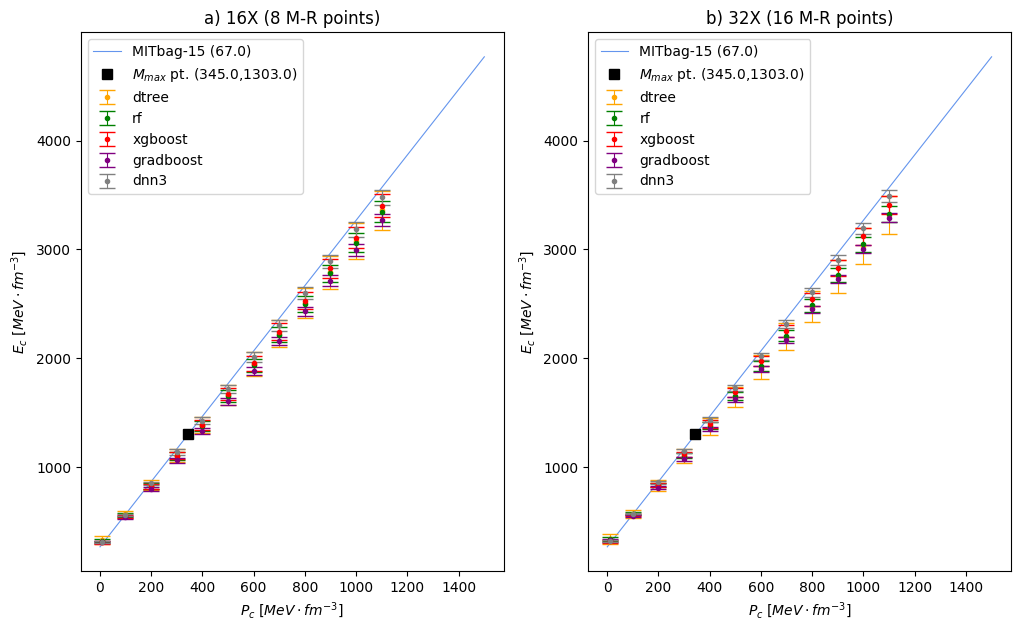

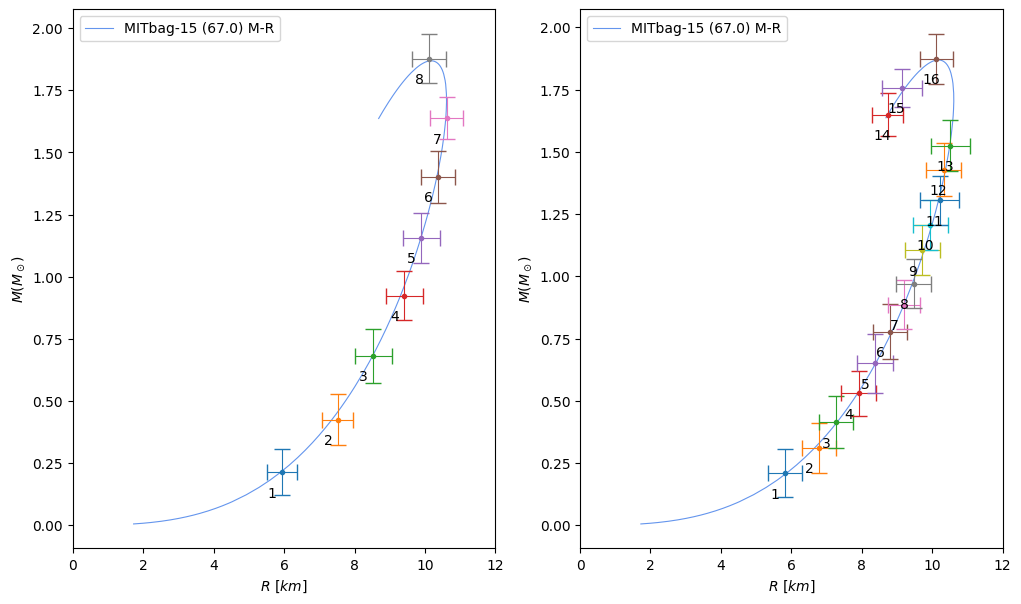

In [4]:
fig_MITbag15_EOS, axes_EOS = plt.subplots(1,2,figsize=(12,7))
fig_MITbag15_MR, axes_MR = plt.subplots(1,2,figsize=(12,7))

# 8 M-R points
predict_EOS_mitbagQS(axis_EOS=axes_EOS[0],axis_MR=axes_MR[0],mitbag_EOS="MITbag-15",include_Mmax=True,reg_models_infos=models_16X_infos,points_MR=8,Pc_points=Pc_pts,iterations=100)
# 16 M-R points
predict_EOS_mitbagQS(axis_EOS=axes_EOS[1],axis_MR=axes_MR[1],mitbag_EOS="MITbag-15",include_Mmax=True,reg_models_infos=models_32X_infos,points_MR=16,Pc_points=Pc_pts,iterations=100)

axes_EOS[0].set_title("a) 16X (8 M-R points)")
axes_EOS[1].set_title("b) 32X (16 M-R points)")

fig_MITbag15_EOS.savefig("MITbag-15_EOS_predict.png",dpi=300)
fig_MITbag15_MR.savefig("MITbag-15_MR_predict.png",dpi=300)

## **2.2 MITbag-18 ($B=68.5$ $MeV\cdot fm^{-3}$) results**

> MITbag-18

>> POINTS M-R: 8
---------------------------------------------------------------------
Regression models and MSLE:
dtree:  0.00771704781135234
rf:  0.005322398852581205
xgboost:  0.00343405169700723
gradboost:  0.006995543735182319
dnn3:  0.0014408389540971984
---------------------------------------------------------------------
Best model:
dnn3
Best model MSLE:
0.0014408389540971984
---------------------------------------------------------------------


> MITbag-18

>> POINTS M-R: 16
---------------------------------------------------------------------
Regression models and MSLE:
dtree:  0.010461262113722211
rf:  0.005739747319013764
xgboost:  0.0029367244861321705
gradboost:  0.0065376802734901296
dnn3:  0.0011317671015559562
---------------------------------------------------------------------
Best model:
dnn3
Best model MSLE:
0.0011317671015559562
---------------------------------------------------------------------




Text(0.5, 1.0, 'b) 32X (16 M-R points)')

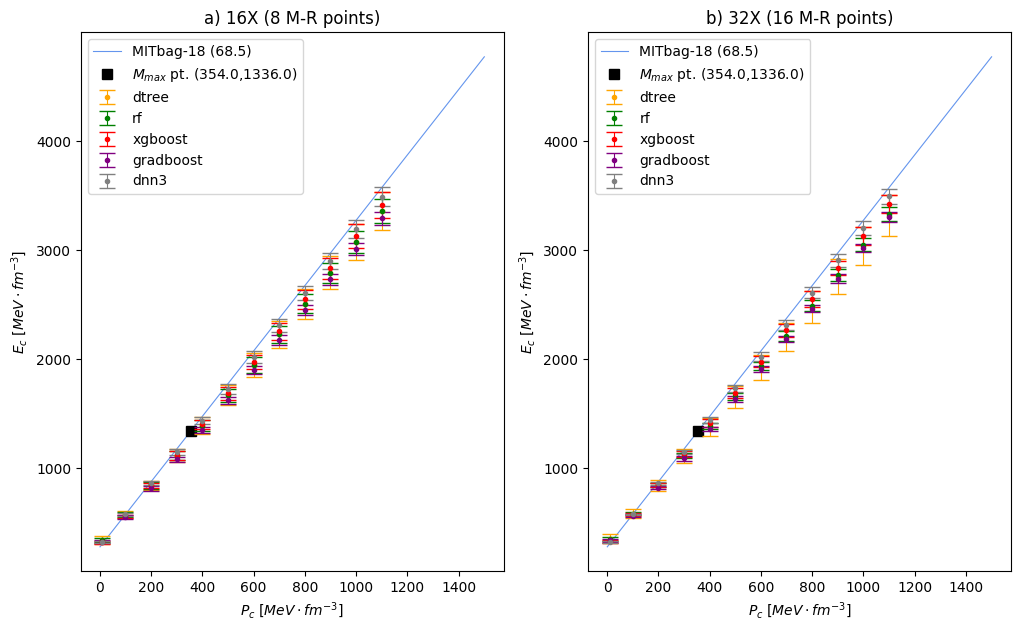

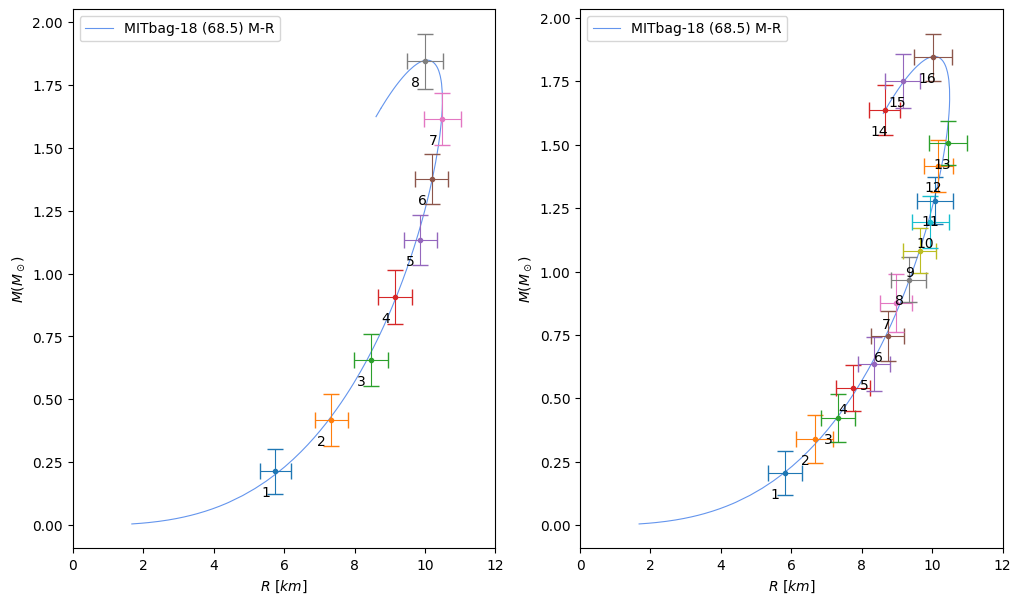

In [6]:
fig_MITbag18_EOS, axes_EOS = plt.subplots(1,2,figsize=(12,7))
fig_MITbag18_MR, axes_MR = plt.subplots(1,2,figsize=(12,7))

# 8 M-R points
predict_EOS_mitbagQS(axis_EOS=axes_EOS[0],axis_MR=axes_MR[0],mitbag_EOS="MITbag-18",include_Mmax=True,reg_models_infos=models_16X_infos,points_MR=8,Pc_points=Pc_pts,iterations=100)
# 16 M-R points
predict_EOS_mitbagQS(axis_EOS=axes_EOS[1],axis_MR=axes_MR[1],mitbag_EOS="MITbag-18",include_Mmax=True,reg_models_infos=models_32X_infos,points_MR=16,Pc_points=Pc_pts,iterations=100)

axes_EOS[0].set_title("a) 16X (8 M-R points)")
axes_EOS[1].set_title("b) 32X (16 M-R points)")

## **2.3 MITbag-86 ($B=102.5$ $MeV\cdot fm^{-3}$) results**

> MITbag-86

>> POINTS M-R: 8
---------------------------------------------------------------------
Regression models and MSLE:
dtree:  0.006085577479226873
rf:  0.004388623975631511
xgboost:  0.0036593817444644395
gradboost:  0.00517720799298456
dnn3:  0.002510554465985596
---------------------------------------------------------------------
Best model:
dnn3
Best model MSLE:
0.002510554465985596
---------------------------------------------------------------------


> MITbag-86

>> POINTS M-R: 16
---------------------------------------------------------------------
Regression models and MSLE:
dtree:  0.007058478934869689
rf:  0.004002848116427159
xgboost:  0.0032740077600840896
gradboost:  0.005065199533614
dnn3:  0.0015520283938938414
---------------------------------------------------------------------
Best model:
dnn3
Best model MSLE:
0.0015520283938938414
---------------------------------------------------------------------




Text(0.5, 1.0, 'b) 32X (16 M-R points)')

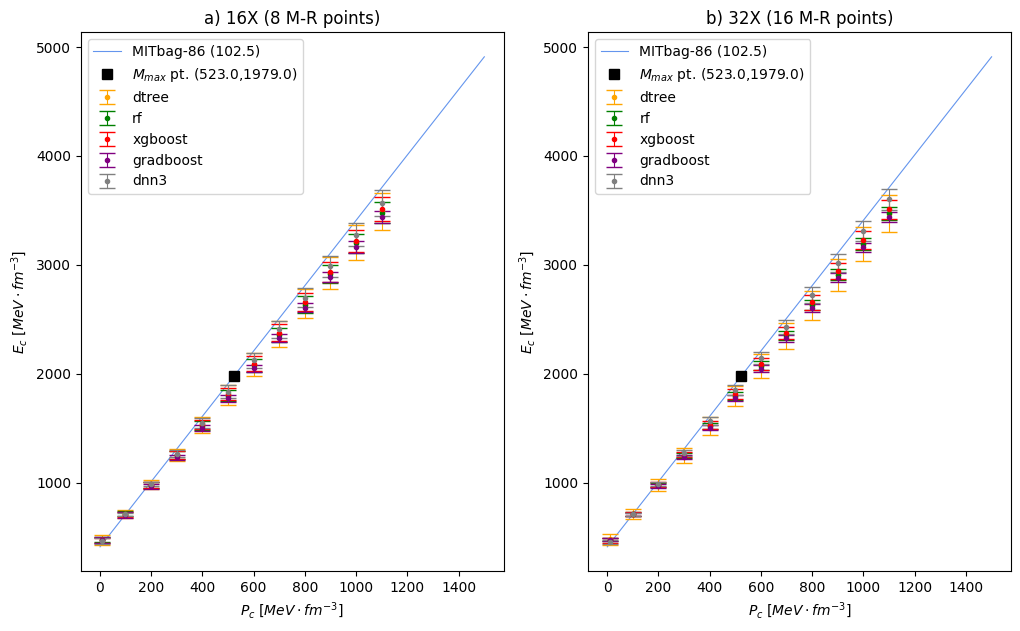

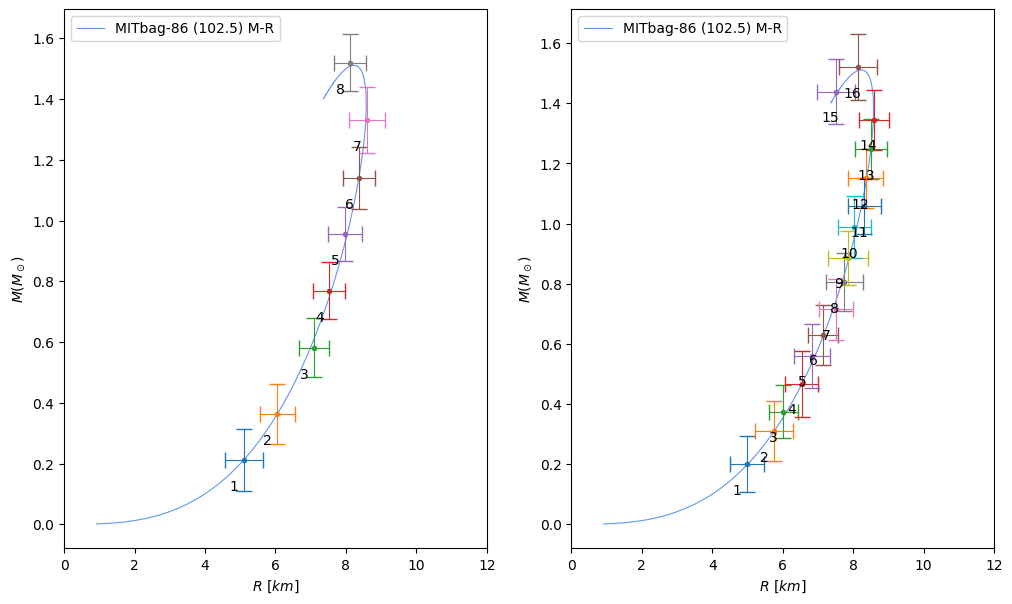

In [7]:
fig_MITbag86_EOS, axes_EOS = plt.subplots(1,2,figsize=(12,7))
fig_MITbag86_MR, axes_MR = plt.subplots(1,2,figsize=(12,7))

# 8 M-R points
predict_EOS_mitbagQS(axis_EOS=axes_EOS[0],axis_MR=axes_MR[0],mitbag_EOS="MITbag-86",include_Mmax=True,reg_models_infos=models_16X_infos,points_MR=8,Pc_points=Pc_pts,iterations=100)
# 16 M-R points
predict_EOS_mitbagQS(axis_EOS=axes_EOS[1],axis_MR=axes_MR[1],mitbag_EOS="MITbag-86",include_Mmax=True,reg_models_infos=models_32X_infos,points_MR=16,Pc_points=Pc_pts,iterations=100)

axes_EOS[0].set_title("a) 16X (8 M-R points)")
axes_EOS[1].set_title("b) 32X (16 M-R points)")

## **2.4 MITbag-134 ($B=126.5$ $MeV\cdot fm^{-3}$) results**

> MITbag-134

>> POINTS M-R: 8
---------------------------------------------------------------------
Regression models and MSLE:
dtree:  0.005861476472809018
rf:  0.0028587747013997127
xgboost:  0.0025599781340414
gradboost:  0.003614578112897508
dnn3:  0.0024768105800053596
---------------------------------------------------------------------
Best model:
dnn3
Best model MSLE:
0.0024768105800053596
---------------------------------------------------------------------


> MITbag-134

>> POINTS M-R: 16
---------------------------------------------------------------------
Regression models and MSLE:
dtree:  0.004627847036202785
rf:  0.0030776517884669907
xgboost:  0.0024733288212070844
gradboost:  0.003339212963325269
dnn3:  0.001069937612963717
---------------------------------------------------------------------
Best model:
dnn3
Best model MSLE:
0.001069937612963717
---------------------------------------------------------------------




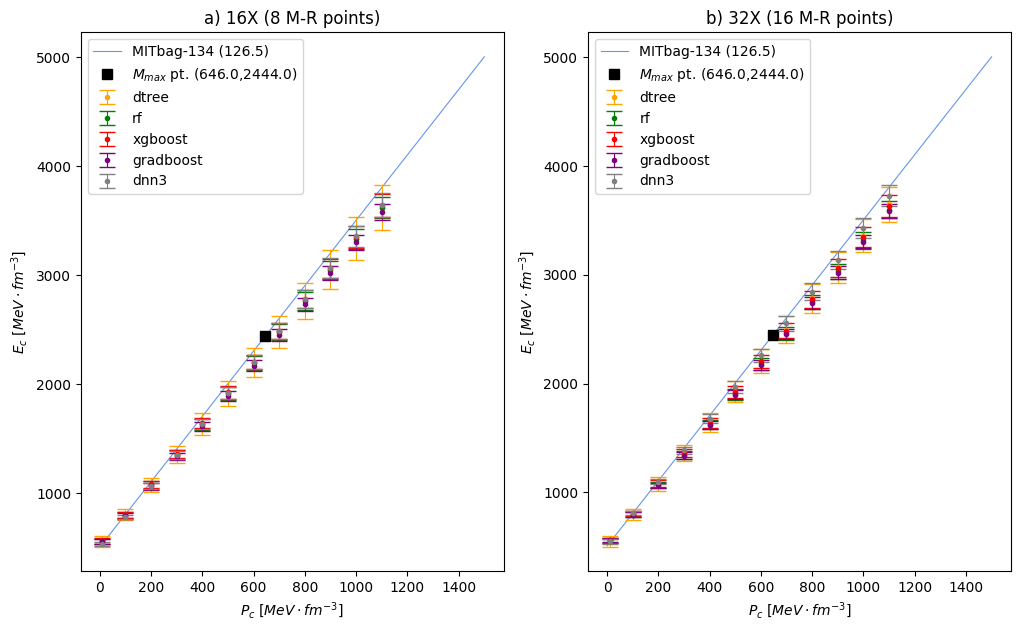

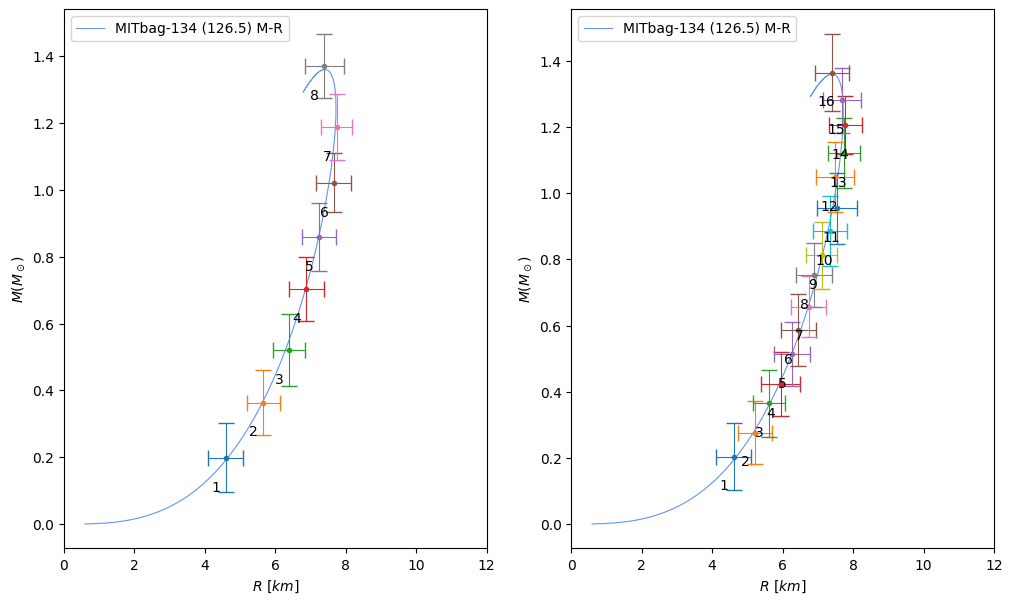

In [5]:
fig_MITbag134_EOS, axes_EOS = plt.subplots(1,2,figsize=(12,7))
fig_MITbag134_MR, axes_MR = plt.subplots(1,2,figsize=(12,7))

# 8 M-R points
predict_EOS_mitbagQS(axis_EOS=axes_EOS[0],axis_MR=axes_MR[0],mitbag_EOS="MITbag-134",include_Mmax=True,reg_models_infos=models_16X_infos,points_MR=8,Pc_points=Pc_pts,iterations=100)
# 16 M-R points
predict_EOS_mitbagQS(axis_EOS=axes_EOS[1],axis_MR=axes_MR[1],mitbag_EOS="MITbag-134",include_Mmax=True,reg_models_infos=models_32X_infos,points_MR=16,Pc_points=Pc_pts,iterations=100)

axes_EOS[0].set_title("a) 16X (8 M-R points)")
axes_EOS[1].set_title("b) 32X (16 M-R points)")

fig_MITbag134_EOS.savefig("MITbag-134_EOS_predict.png",dpi=300)

## **2.5 MITbag-197 ($B=158$ $MeV\cdot fm^{-3}$) results**

> MITbag-197

>> POINTS M-R: 8
---------------------------------------------------------------------
Regression models and MSLE:
dtree:  0.0028824918656102107
rf:  0.0011556426491845552
xgboost:  0.0011905377485024315
gradboost:  0.001459647182695314
dnn3:  0.0007913259693712874
---------------------------------------------------------------------
Best model:
dnn3
Best model MSLE:
0.0007913259693712874
---------------------------------------------------------------------


> MITbag-197

>> POINTS M-R: 16
---------------------------------------------------------------------
Regression models and MSLE:
dtree:  0.0031645294784669476
rf:  0.0009093338540253426
xgboost:  0.0008755248768896502
gradboost:  0.0011084469600374804
dnn3:  0.0005506333212596989
---------------------------------------------------------------------
Best model:
dnn3
Best model MSLE:
0.0005506333212596989
---------------------------------------------------------------------




Text(0.5, 1.0, 'b) 32X (16 M-R points)')

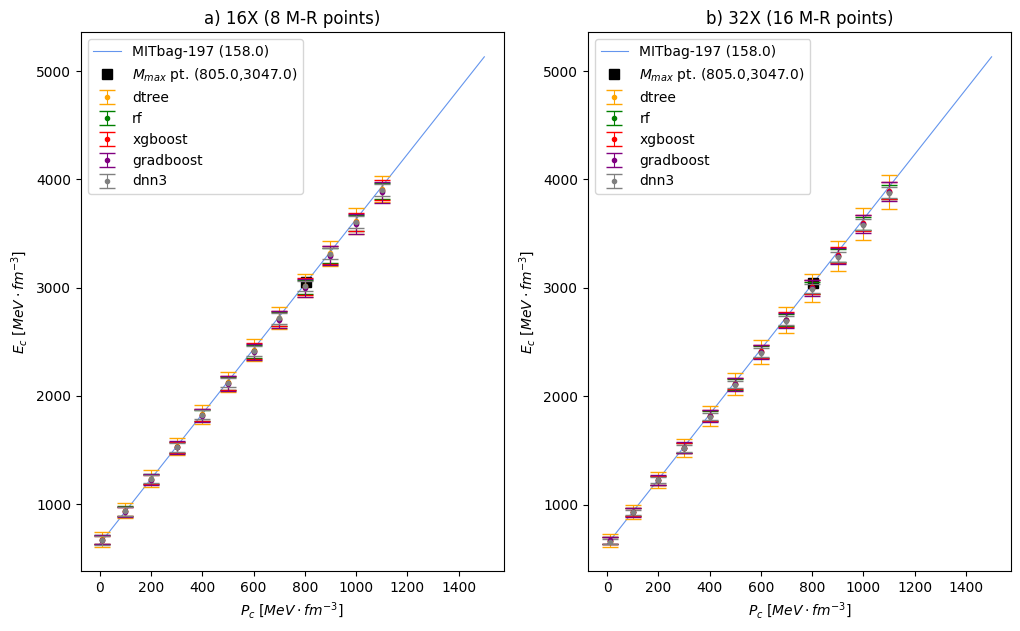

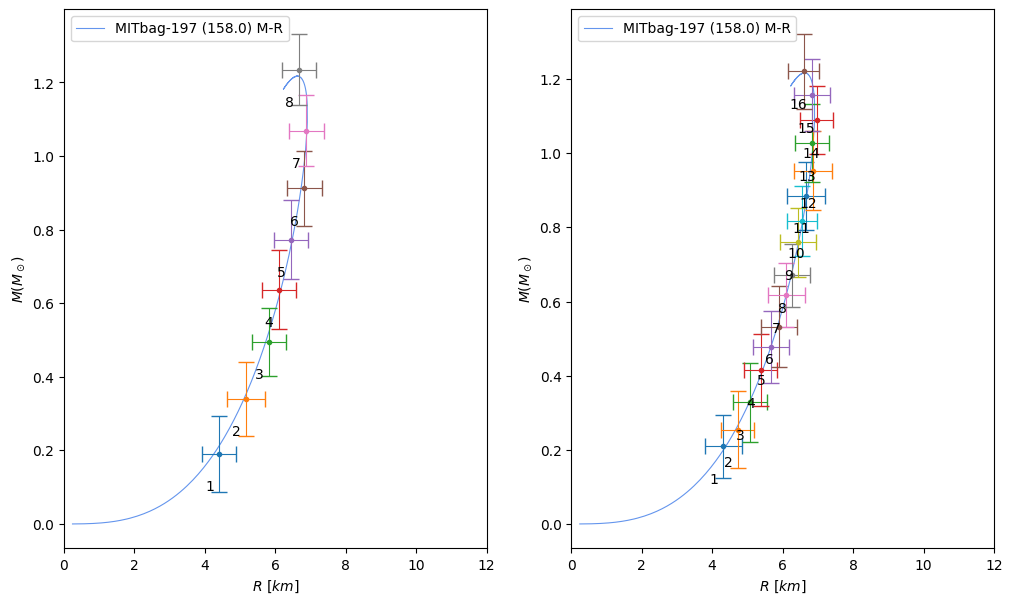

In [9]:
fig_MITbag197_EOS, axes_EOS = plt.subplots(1,2,figsize=(12,7))
fig_MITbag197_MR, axes_MR = plt.subplots(1,2,figsize=(12,7))

# 8 M-R points
predict_EOS_mitbagQS(axis_EOS=axes_EOS[0],axis_MR=axes_MR[0],mitbag_EOS="MITbag-197",include_Mmax=True,reg_models_infos=models_16X_infos,points_MR=8,Pc_points=Pc_pts,iterations=100)
# 16 M-R points
predict_EOS_mitbagQS(axis_EOS=axes_EOS[1],axis_MR=axes_MR[1],mitbag_EOS="MITbag-197",include_Mmax=True,reg_models_infos=models_32X_infos,points_MR=16,Pc_points=Pc_pts,iterations=100)

axes_EOS[0].set_title("a) 16X (8 M-R points)")
axes_EOS[1].set_title("b) 32X (16 M-R points)")

## **2.6 MITbag-227 ($B=173$ $MeV\cdot fm^{-3}$) results**

> MITbag-227

>> POINTS M-R: 8
---------------------------------------------------------------------
Regression models and MSLE:
dtree:  0.002404007985684371
rf:  0.0013834645081606941
xgboost:  0.0012453417989113928
gradboost:  0.0016829981096296279
dnn3:  0.0028449173666826428
---------------------------------------------------------------------
Best model:
xgboost
Best model MSLE:
0.0012453417989113928
---------------------------------------------------------------------


> MITbag-227

>> POINTS M-R: 16
---------------------------------------------------------------------
Regression models and MSLE:
dtree:  0.003626669920588669
rf:  0.0008446512586470907
xgboost:  0.0008675656702814387
gradboost:  0.0011716027100343931
dnn3:  0.0005238200814998025
---------------------------------------------------------------------
Best model:
dnn3
Best model MSLE:
0.0005238200814998025
---------------------------------------------------------------------




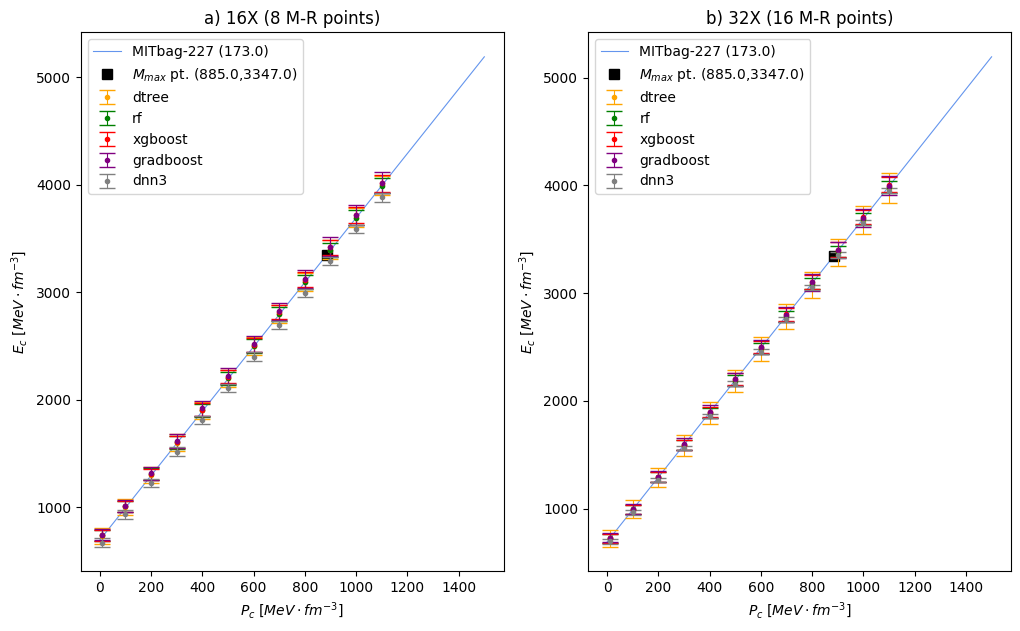

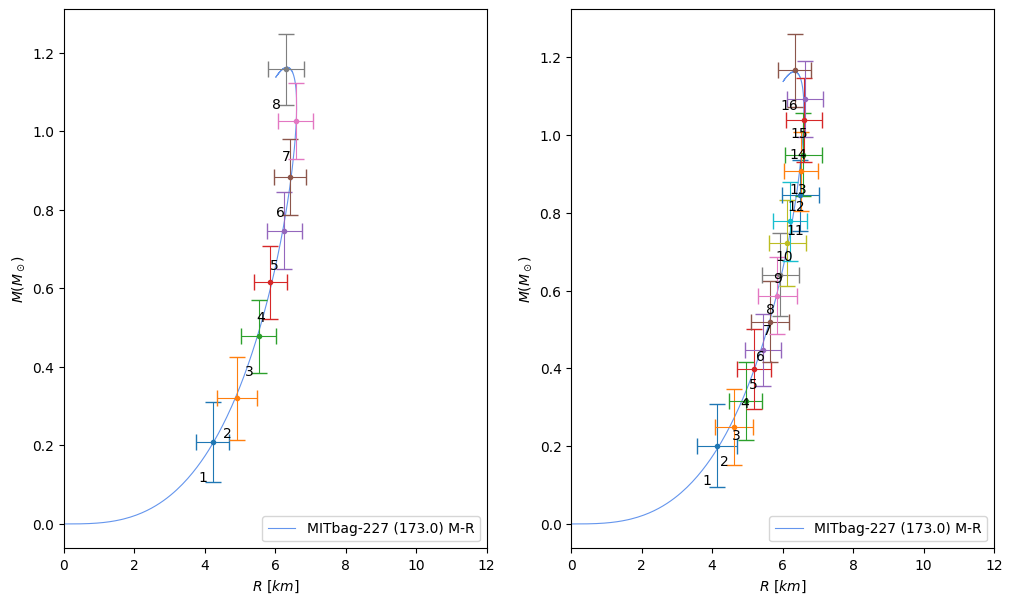

In [6]:
fig_MITbag227_EOS, axes_EOS = plt.subplots(1,2,figsize=(12,7))
fig_MITbag227_MR, axes_MR = plt.subplots(1,2,figsize=(12,7))

# 8 M-R points
predict_EOS_mitbagQS(axis_EOS=axes_EOS[0],axis_MR=axes_MR[0],mitbag_EOS="MITbag-227",include_Mmax=True,reg_models_infos=models_16X_infos,points_MR=8,Pc_points=Pc_pts,iterations=100)
# 16 M-R points
predict_EOS_mitbagQS(axis_EOS=axes_EOS[1],axis_MR=axes_MR[1],mitbag_EOS="MITbag-227",include_Mmax=True,reg_models_infos=models_32X_infos,points_MR=16,Pc_points=Pc_pts,iterations=100)

axes_EOS[0].set_title("a) 16X (8 M-R points)")
axes_EOS[1].set_title("b) 32X (16 M-R points)")

fig_MITbag227_EOS.savefig("MITbag-227_EOS_predict.png",dpi=300)

## **2.7 MITbag-274 ($B=196.5$ $MeV\cdot fm^{-3}$) results**

> MITbag-274

>> POINTS M-R: 8
---------------------------------------------------------------------
Regression models and MSLE:
dtree:  0.002457846640114537
rf:  0.0009172748943564278
xgboost:  0.0009342683535524046
gradboost:  0.0009967510924802317
dnn3:  0.0005256066105177834
---------------------------------------------------------------------
Best model:
dnn3
Best model MSLE:
0.0005256066105177834
---------------------------------------------------------------------


> MITbag-274

>> POINTS M-R: 16
---------------------------------------------------------------------
Regression models and MSLE:
dtree:  0.0021050197750651987
rf:  0.0005552032018927205
xgboost:  0.0006756009100812537
gradboost:  0.0008538255665965114
dnn3:  0.00040274911245153294
---------------------------------------------------------------------
Best model:
dnn3
Best model MSLE:
0.00040274911245153294
---------------------------------------------------------------------




Text(0.5, 1.0, 'b) 32X (16 M-R points)')

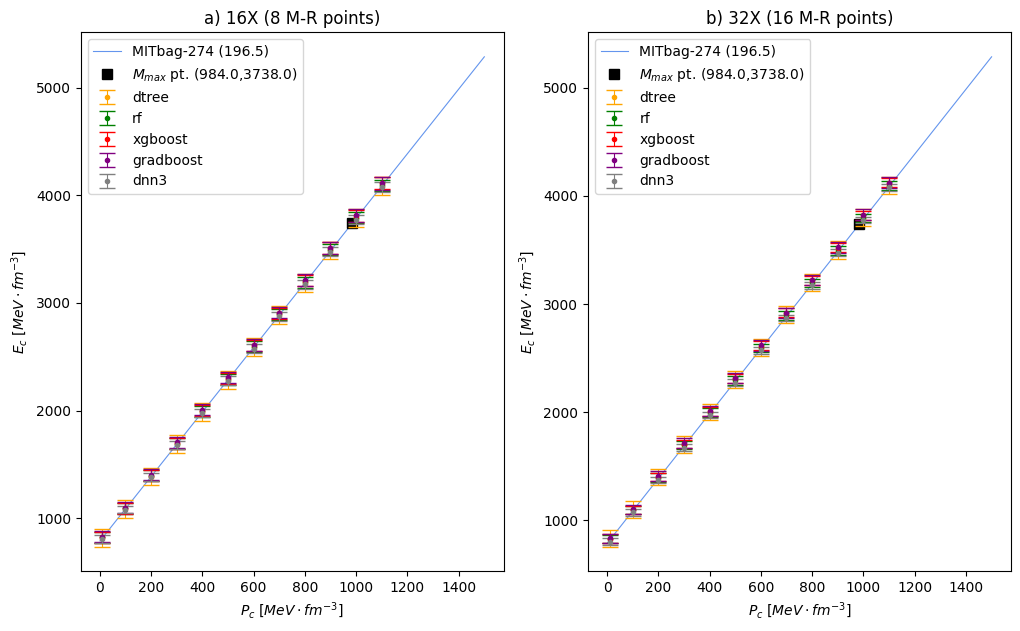

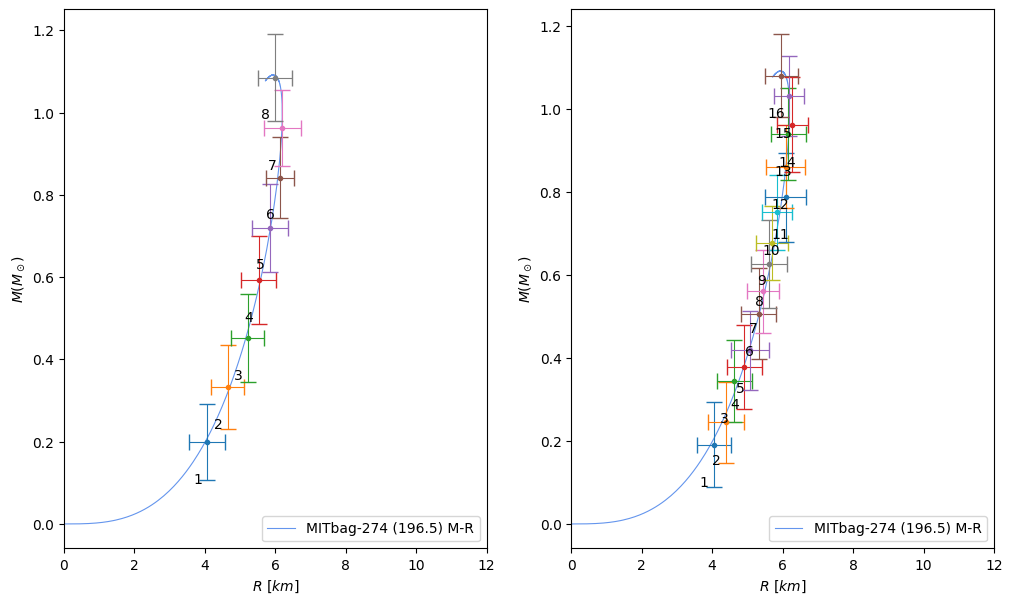

In [11]:
fig_MITbag274_EOS, axes_EOS = plt.subplots(1,2,figsize=(12,7))
fig_MITbag274_MR, axes_MR = plt.subplots(1,2,figsize=(12,7))

# 8 M-R points
predict_EOS_mitbagQS(axis_EOS=axes_EOS[0],axis_MR=axes_MR[0],mitbag_EOS="MITbag-274",include_Mmax=True,reg_models_infos=models_16X_infos,points_MR=8,Pc_points=Pc_pts,iterations=100)
# 16 M-R points
predict_EOS_mitbagQS(axis_EOS=axes_EOS[1],axis_MR=axes_MR[1],mitbag_EOS="MITbag-274",include_Mmax=True,reg_models_infos=models_32X_infos,points_MR=16,Pc_points=Pc_pts,iterations=100)

axes_EOS[0].set_title("a) 16X (8 M-R points)")
axes_EOS[1].set_title("b) 32X (16 M-R points)")

## **2.8 MITbag-297 ($B=208$ $MeV\cdot fm^{-3}$) results**

> MITbag-297

>> POINTS M-R: 8
---------------------------------------------------------------------
Regression models and MSLE:
dtree:  0.0018288891243371883
rf:  0.000994021751749819
xgboost:  0.0009244340423126699
gradboost:  0.0009680501321939973
dnn3:  0.0006081895038772981
---------------------------------------------------------------------
Best model:
dnn3
Best model MSLE:
0.0006081895038772981
---------------------------------------------------------------------


> MITbag-297

>> POINTS M-R: 16
---------------------------------------------------------------------
Regression models and MSLE:
dtree:  0.0016771388338211494
rf:  0.0006021963756875436
xgboost:  0.000652756578148865
gradboost:  0.0005475301226970887
dnn3:  0.0004956849551448146
---------------------------------------------------------------------
Best model:
dnn3
Best model MSLE:
0.0004956849551448146
---------------------------------------------------------------------




Text(0.5, 1.0, 'b) 32X (16 M-R points)')

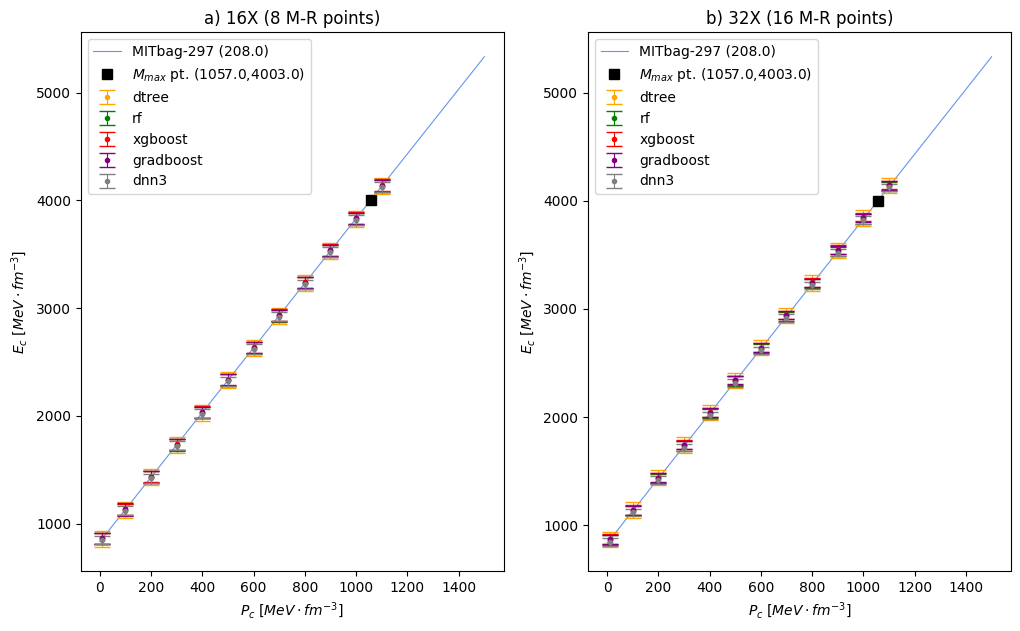

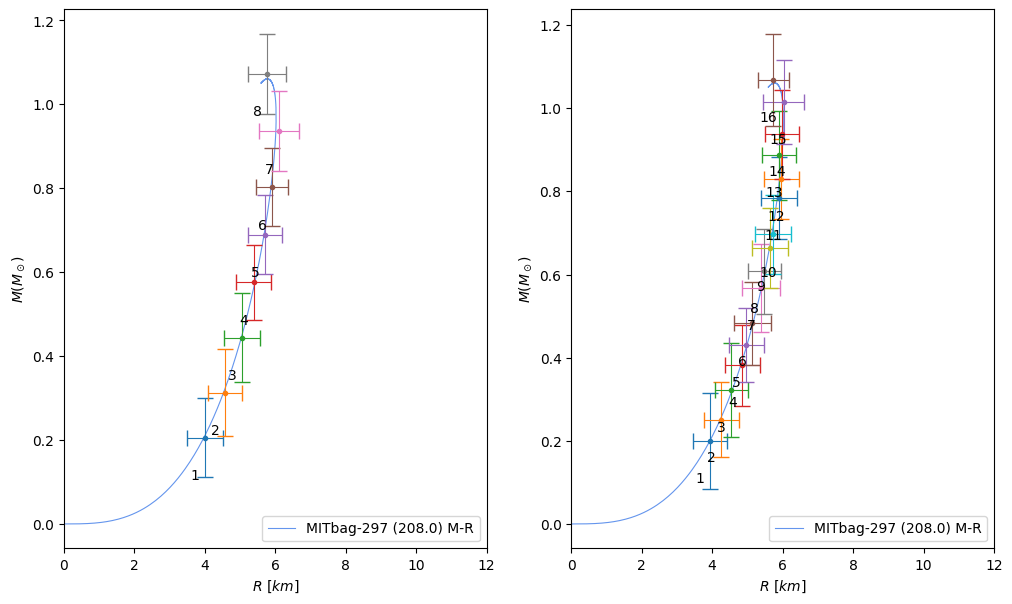

In [12]:
fig_MITbag297_EOS, axes_EOS = plt.subplots(1,2,figsize=(12,7))
fig_MITbag297_MR, axes_MR = plt.subplots(1,2,figsize=(12,7))

# 8 M-R points
predict_EOS_mitbagQS(axis_EOS=axes_EOS[0],axis_MR=axes_MR[0],mitbag_EOS="MITbag-297",include_Mmax=True,reg_models_infos=models_16X_infos,points_MR=8,Pc_points=Pc_pts,iterations=100)
# 16 M-R points
predict_EOS_mitbagQS(axis_EOS=axes_EOS[1],axis_MR=axes_MR[1],mitbag_EOS="MITbag-297",include_Mmax=True,reg_models_infos=models_32X_infos,points_MR=16,Pc_points=Pc_pts,iterations=100)

axes_EOS[0].set_title("a) 16X (8 M-R points)")
axes_EOS[1].set_title("b) 32X (16 M-R points)")

## **2.9 MITbag-315 ($B=217$ $MeV\cdot fm^{-3}$) results**

> MITbag-315

>> POINTS M-R: 8
---------------------------------------------------------------------
Regression models and MSLE:
dtree:  0.0016761289471258383
rf:  0.0007799978319545232
xgboost:  0.0006318937826471405
gradboost:  0.0004901449940549046
dnn3:  0.003639556379432591
---------------------------------------------------------------------
Best model:
gradboost
Best model MSLE:
0.0004901449940549046
---------------------------------------------------------------------


> MITbag-315

>> POINTS M-R: 16
---------------------------------------------------------------------
Regression models and MSLE:
dtree:  0.0014234025270567195
rf:  0.0003587616879534565
xgboost:  0.0003567359652892335
gradboost:  0.00026644150155376956
dnn3:  0.001092112075858062
---------------------------------------------------------------------
Best model:
gradboost
Best model MSLE:
0.00026644150155376956
---------------------------------------------------------------------




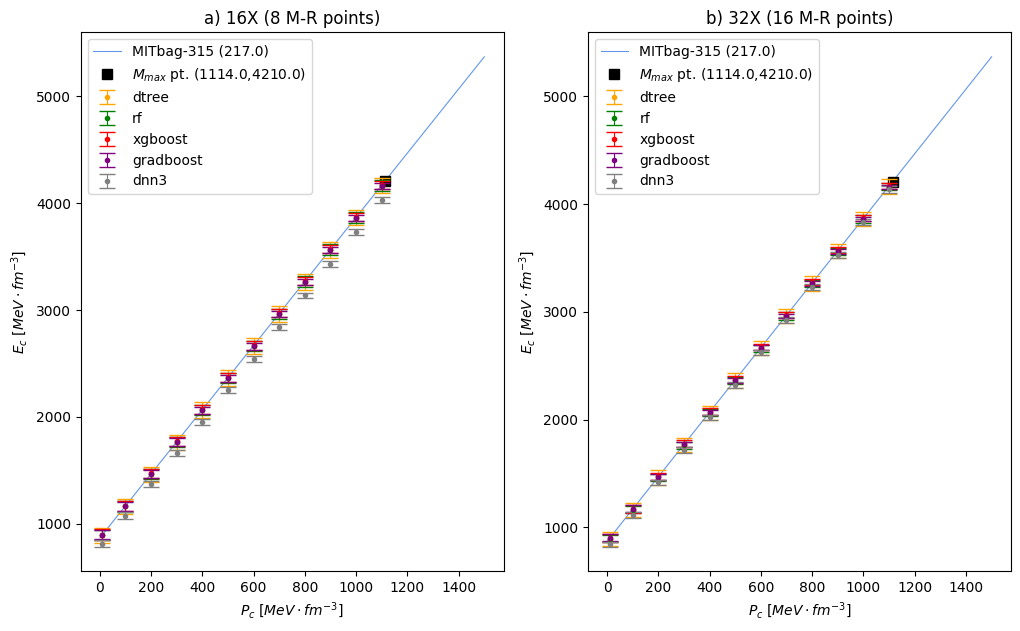

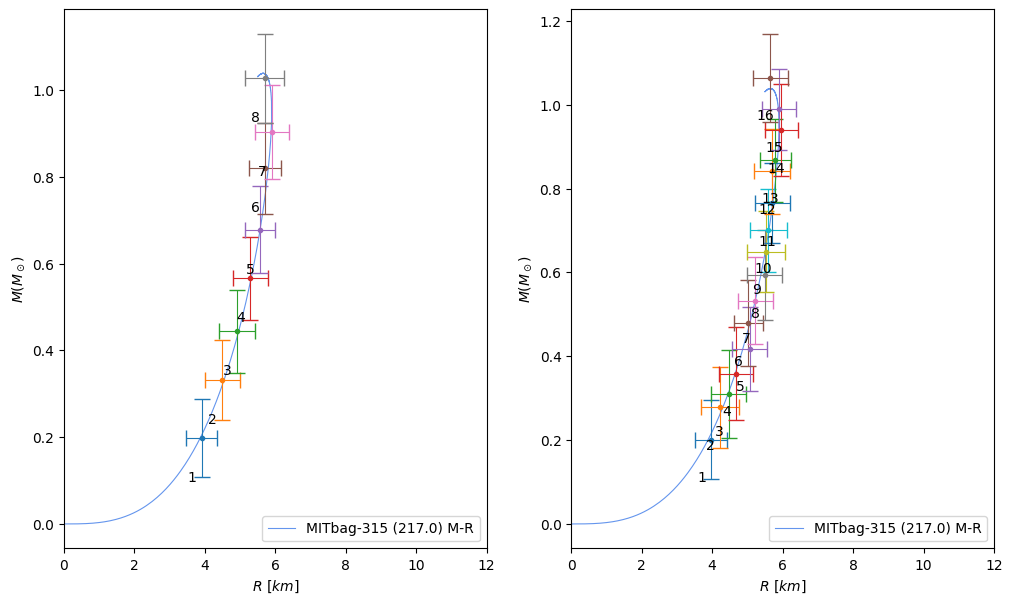

In [7]:
fig_MITbag315_EOS, axes_EOS = plt.subplots(1,2,figsize=(12,7))
fig_MITbag315_MR, axes_MR = plt.subplots(1,2,figsize=(12,7))

# 8 M-R points
predict_EOS_mitbagQS(axis_EOS=axes_EOS[0],axis_MR=axes_MR[0],mitbag_EOS="MITbag-315",include_Mmax=True,reg_models_infos=models_16X_infos,points_MR=8,Pc_points=Pc_pts,iterations=100)
# 16 M-R points
predict_EOS_mitbagQS(axis_EOS=axes_EOS[1],axis_MR=axes_MR[1],mitbag_EOS="MITbag-315",include_Mmax=True,reg_models_infos=models_32X_infos,points_MR=16,Pc_points=Pc_pts,iterations=100)

axes_EOS[0].set_title("a) 16X (8 M-R points)")
axes_EOS[1].set_title("b) 32X (16 M-R points)")

fig_MITbag315_EOS.savefig("MITbag-315_EOS_predict.png",dpi=300)

## **2.10 MITbag-367 ($B=218$ $MeV\cdot fm^{-3}$) results**

> MITbag-367

>> POINTS M-R: 8
---------------------------------------------------------------------
Regression models and MSLE:
dtree:  0.001372040329000697
rf:  0.0010800374327948638
xgboost:  0.0008596750773671636
gradboost:  0.0014879655415885294
dnn3:  0.001265046665433741
---------------------------------------------------------------------
Best model:
xgboost
Best model MSLE:
0.0008596750773671636
---------------------------------------------------------------------


> MITbag-367

>> POINTS M-R: 16
---------------------------------------------------------------------
Regression models and MSLE:
dtree:  0.0016048495537790278
rf:  0.0010901366218468052
xgboost:  0.0007371938118036742
gradboost:  0.0014161430695339738
dnn3:  0.0008596002009539887
---------------------------------------------------------------------
Best model:
xgboost
Best model MSLE:
0.0007371938118036742
---------------------------------------------------------------------




Text(0.5, 1.0, 'b) 32X (16 M-R points)')

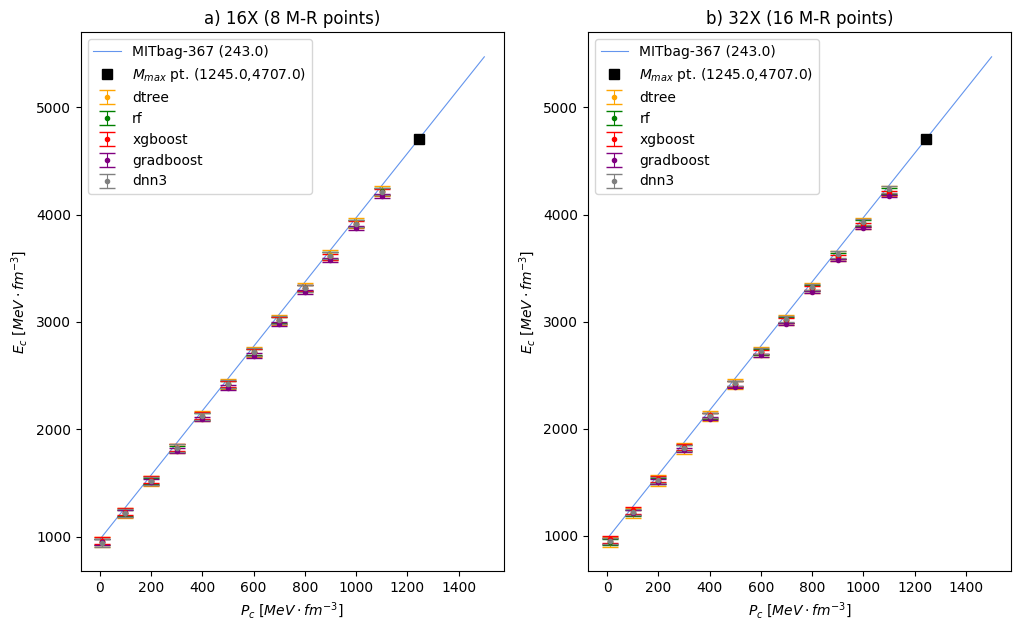

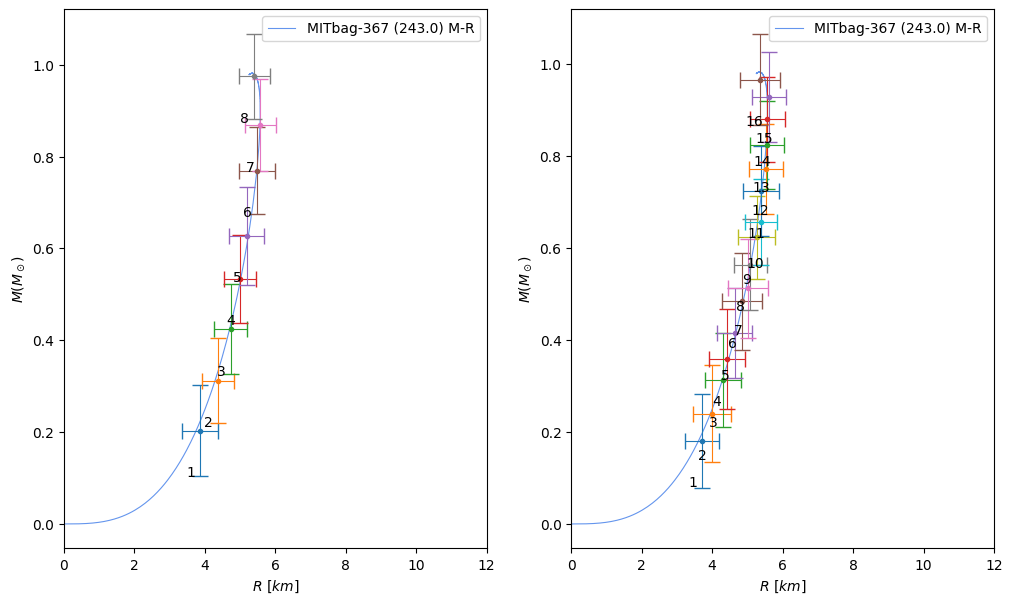

In [14]:
fig_MITbag367_EOS, axes_EOS = plt.subplots(1,2,figsize=(12,7))
fig_MITbag367_MR, axes_MR = plt.subplots(1,2,figsize=(12,7))

# 8 M-R points
predict_EOS_mitbagQS(axis_EOS=axes_EOS[0],axis_MR=axes_MR[0],mitbag_EOS="MITbag-367",include_Mmax=True,reg_models_infos=models_16X_infos,points_MR=8,Pc_points=Pc_pts,iterations=100)
# 16 M-R points
predict_EOS_mitbagQS(axis_EOS=axes_EOS[1],axis_MR=axes_MR[1],mitbag_EOS="MITbag-367",include_Mmax=True,reg_models_infos=models_32X_infos,points_MR=16,Pc_points=Pc_pts,iterations=100)

axes_EOS[0].set_title("a) 16X (8 M-R points)")
axes_EOS[1].set_title("b) 32X (16 M-R points)")

# 3. Predicting CFL EOSs

## **3.1 CFL-8 ($B=60$ $MeV\cdot fm^{-3}$, $Δ=120$ $MeV$) results**

> CFL-8

>> POINTS M-R: 8
---------------------------------------------------------------------
Regression models and MSLE:
dtree:  0.015811524543671362
rf:  0.012205033903804641
xgboost:  0.010336725555562887
gradboost:  0.015023119779075993
dnn3:  0.002706556024283104
---------------------------------------------------------------------
Best model:
dnn3
Best model MSLE:
0.002706556024283104
---------------------------------------------------------------------


> CFL-8

>> POINTS M-R: 16
---------------------------------------------------------------------
Regression models and MSLE:
dtree:  0.017755786374451573
rf:  0.011511408815273337
xgboost:  0.00937325400050174
gradboost:  0.014428616534039845
dnn3:  0.0015878262241751393
---------------------------------------------------------------------
Best model:
dnn3
Best model MSLE:
0.0015878262241751393
---------------------------------------------------------------------




Text(0.5, 1.0, 'b) 32X (16 M-R points)')

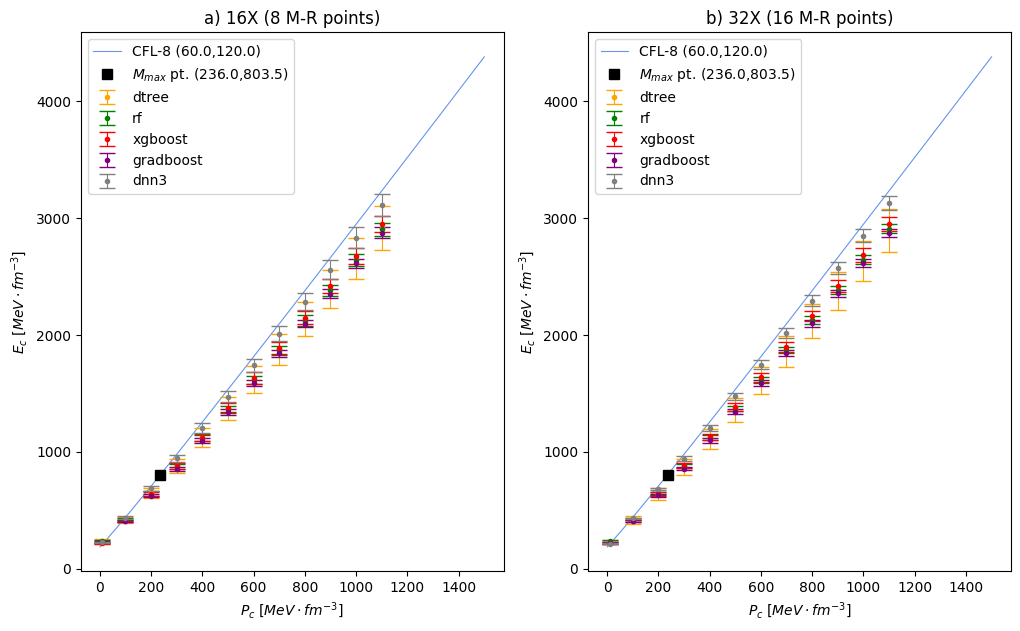

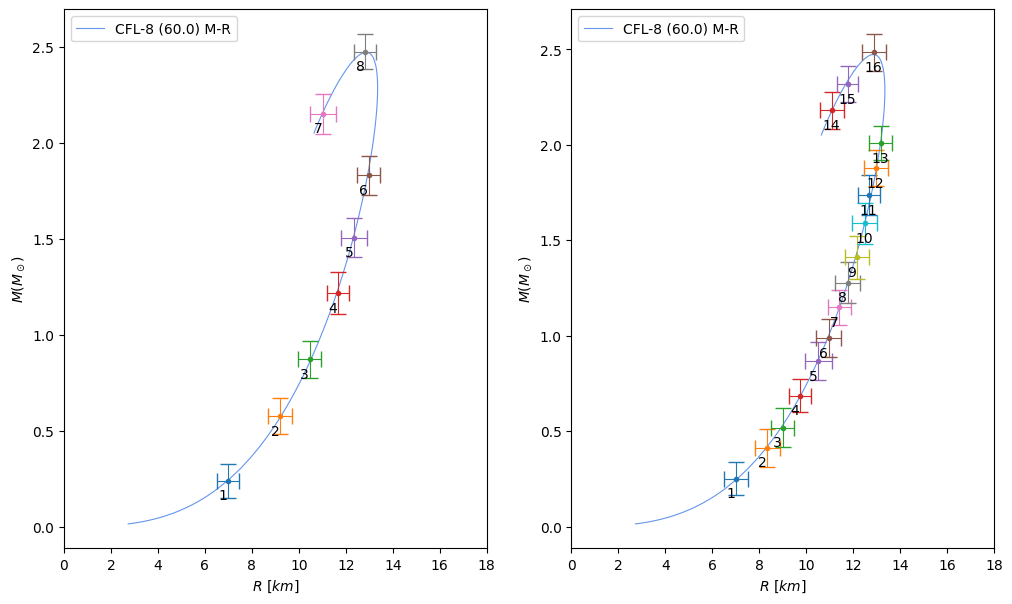

In [ ]:
fig_CFL8_EOS, axes_EOS = plt.subplots(1,2,figsize=(12,7))
fig_CFL8_MR, axes_MR = plt.subplots(1,2,figsize=(12,7))

# 8 M-R points
predict_EOS_cflQS(axis_EOS=axes_EOS[0],axis_MR=axes_MR[0],cfl_EOS="CFL-8",include_Mmax=True,reg_models_infos=models_16X_infos,points_MR=8,Pc_points=Pc_pts,iterations=100)
# 16 M-R points
predict_EOS_cflQS(axis_EOS=axes_EOS[1],axis_MR=axes_MR[1],cfl_EOS="CFL-8",include_Mmax=True,reg_models_infos=models_32X_infos,points_MR=16,Pc_points=Pc_pts,iterations=100)

axes_EOS[0].set_title("a) 16X (8 M-R points)")
axes_EOS[1].set_title("b) 32X (16 M-R points)")


## **3.2 CFL-53 ($B=70$ $MeV\cdot fm^{-3}$, $Δ=150$ $MeV$) results**

> CFL-53

>> POINTS M-R: 8
---------------------------------------------------------------------
Regression models and MSLE:
dtree:  0.009089687510000692
rf:  0.0050058110597612565
xgboost:  0.00470867660231232
gradboost:  0.006325816056027475
dnn3:  0.0031951373407789713
---------------------------------------------------------------------
Best model:
dnn3
Best model MSLE:
0.0031951373407789713
---------------------------------------------------------------------


> CFL-53

>> POINTS M-R: 16
---------------------------------------------------------------------
Regression models and MSLE:
dtree:  0.010853154792821562
rf:  0.005003873141461013
xgboost:  0.004760742808647072
gradboost:  0.0061498120139454925
dnn3:  0.0011008454901680882
---------------------------------------------------------------------
Best model:
dnn3
Best model MSLE:
0.0011008454901680882
---------------------------------------------------------------------




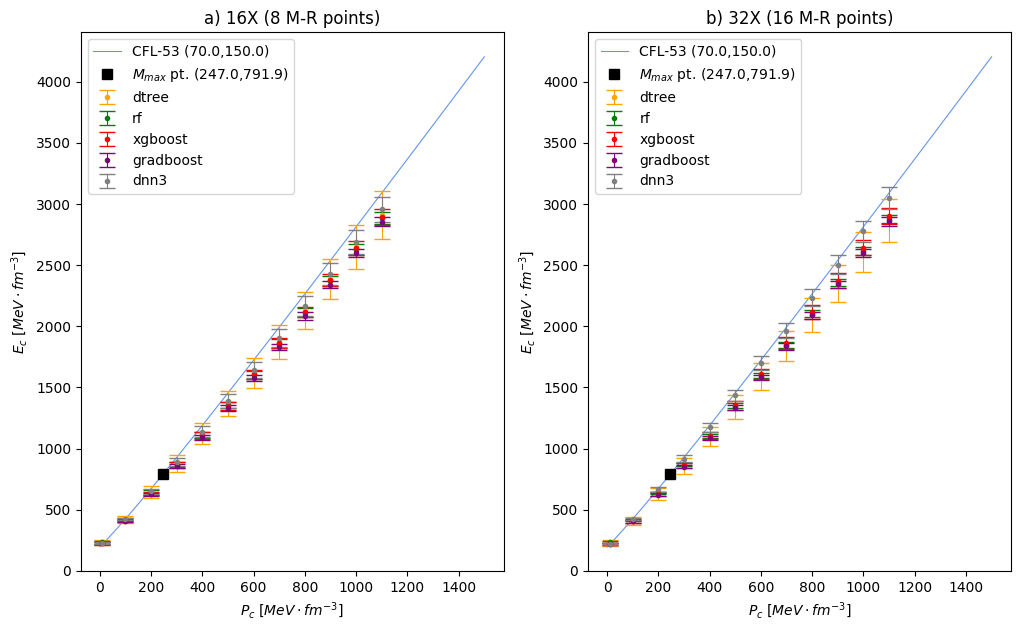

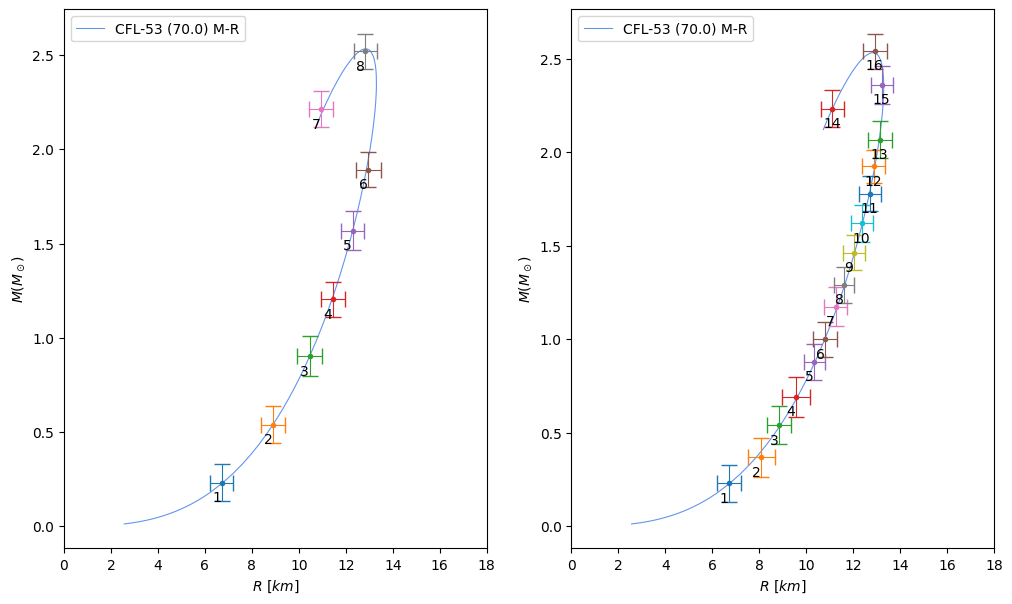

In [10]:
fig_CFL53_EOS, axes_EOS = plt.subplots(1,2,figsize=(12,7))
fig_CFL53_MR, axes_MR = plt.subplots(1,2,figsize=(12,7))

# 8 M-R points
predict_EOS_cflQS(axis_EOS=axes_EOS[0],axis_MR=axes_MR[0],cfl_EOS="CFL-53",include_Mmax=True,reg_models_infos=models_16X_infos,points_MR=8,Pc_points=Pc_pts,iterations=100)
# 16 M-R points
predict_EOS_cflQS(axis_EOS=axes_EOS[1],axis_MR=axes_MR[1],cfl_EOS="CFL-53",include_Mmax=True,reg_models_infos=models_32X_infos,points_MR=16,Pc_points=Pc_pts,iterations=100)

axes_EOS[0].set_title("a) 16X (8 M-R points)")
axes_EOS[1].set_title("b) 32X (16 M-R points)")

fig_CFL53_EOS.savefig("CFL-53_EOS_predict.png",dpi=300)

## **3.3 CFL-75 ($B=75$ $MeV\cdot fm^{-3}$, $Δ=160$ $MeV$) results**

> CFL-75

>> POINTS M-R: 8
---------------------------------------------------------------------
Regression models and MSLE:
dtree:  0.008759565083727988
rf:  0.0030021572523542747
xgboost:  0.0031463446797062398
gradboost:  0.0034574113253639585
dnn3:  0.0026629270977639803
---------------------------------------------------------------------
Best model:
dnn3
Best model MSLE:
0.0026629270977639803
---------------------------------------------------------------------


> CFL-75

>> POINTS M-R: 16
---------------------------------------------------------------------
Regression models and MSLE:
dtree:  0.008098189237560473
rf:  0.0025146212849020883
xgboost:  0.002195645720727926
gradboost:  0.0028854942107631194
dnn3:  0.001358789482599679
---------------------------------------------------------------------
Best model:
dnn3
Best model MSLE:
0.001358789482599679
---------------------------------------------------------------------




Text(0.5, 1.0, 'b) 32X (16 M-R points)')

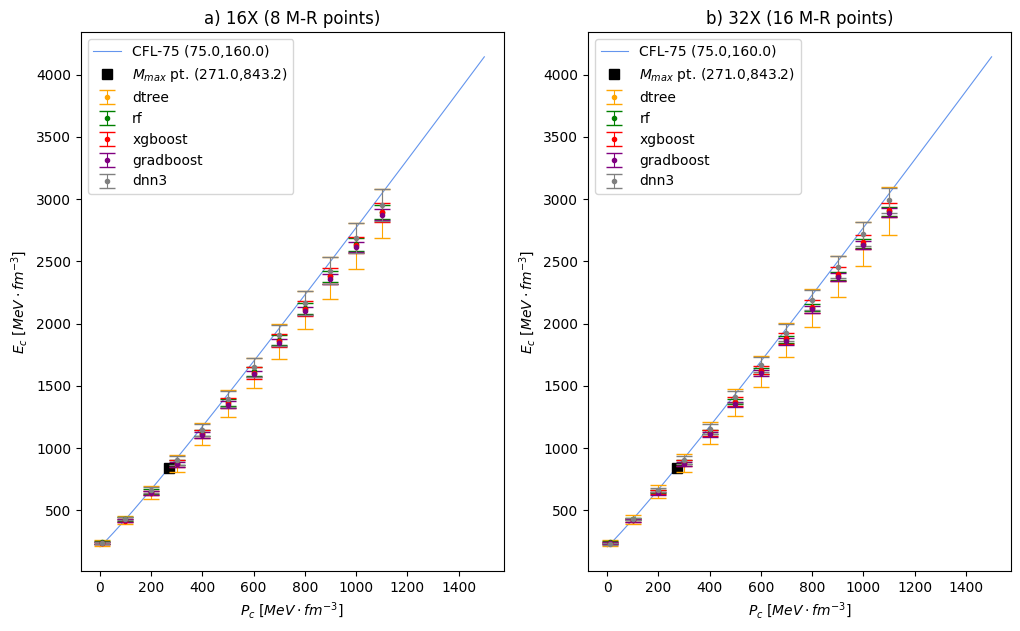

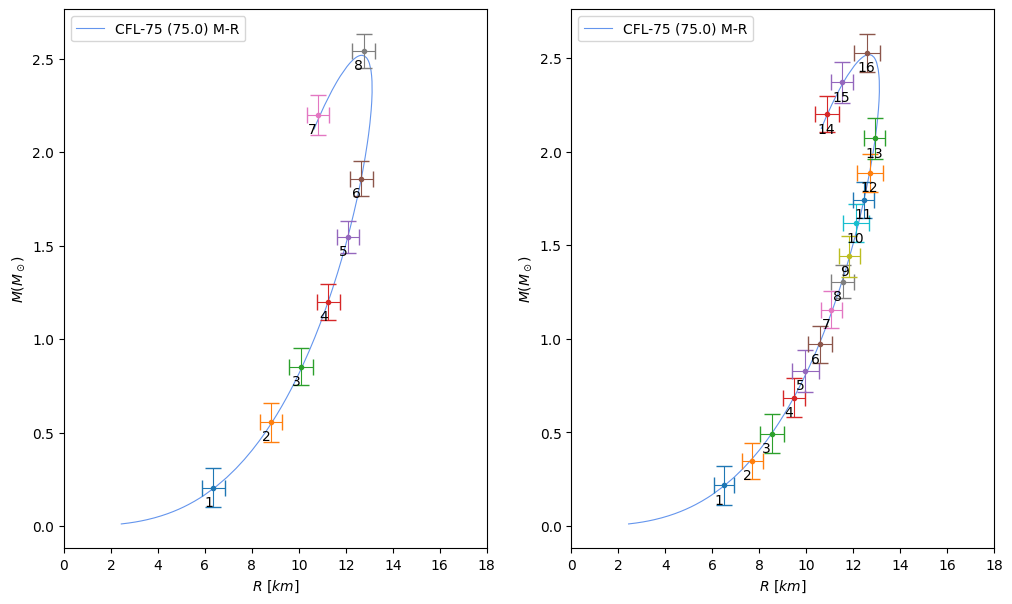

In [17]:
fig_CFL75_EOS, axes_EOS = plt.subplots(1,2,figsize=(12,7))
fig_CFL75_MR, axes_MR = plt.subplots(1,2,figsize=(12,7))

# 8 M-R points
predict_EOS_cflQS(axis_EOS=axes_EOS[0],axis_MR=axes_MR[0],cfl_EOS="CFL-75",include_Mmax=True,reg_models_infos=models_16X_infos,points_MR=8,Pc_points=Pc_pts,iterations=100)
# 16 M-R points
predict_EOS_cflQS(axis_EOS=axes_EOS[1],axis_MR=axes_MR[1],cfl_EOS="CFL-75",include_Mmax=True,reg_models_infos=models_32X_infos,points_MR=16,Pc_points=Pc_pts,iterations=100)

axes_EOS[0].set_title("a) 16X (8 M-R points)")
axes_EOS[1].set_title("b) 32X (16 M-R points)")

## **3.4 CFL-85 ($B=80$ $MeV\cdot fm^{-3}$, $Δ=50$ $MeV$) results**

> CFL-85

>> POINTS M-R: 8
---------------------------------------------------------------------
Regression models and MSLE:
dtree:  0.007022910156481915
rf:  0.0038622033028583125
xgboost:  0.0024918741398875766
gradboost:  0.004354882310861546
dnn3:  0.0014526794760053151
---------------------------------------------------------------------
Best model:
dnn3
Best model MSLE:
0.0014526794760053151
---------------------------------------------------------------------


> CFL-85

>> POINTS M-R: 16
---------------------------------------------------------------------
Regression models and MSLE:
dtree:  0.00934889316471296
rf:  0.004182623158821974
xgboost:  0.0025510389568491293
gradboost:  0.004775892285434999
dnn3:  0.0009995907966101243
---------------------------------------------------------------------
Best model:
dnn3
Best model MSLE:
0.0009995907966101243
---------------------------------------------------------------------




Text(0.5, 1.0, 'b) 32X (16 M-R points)')

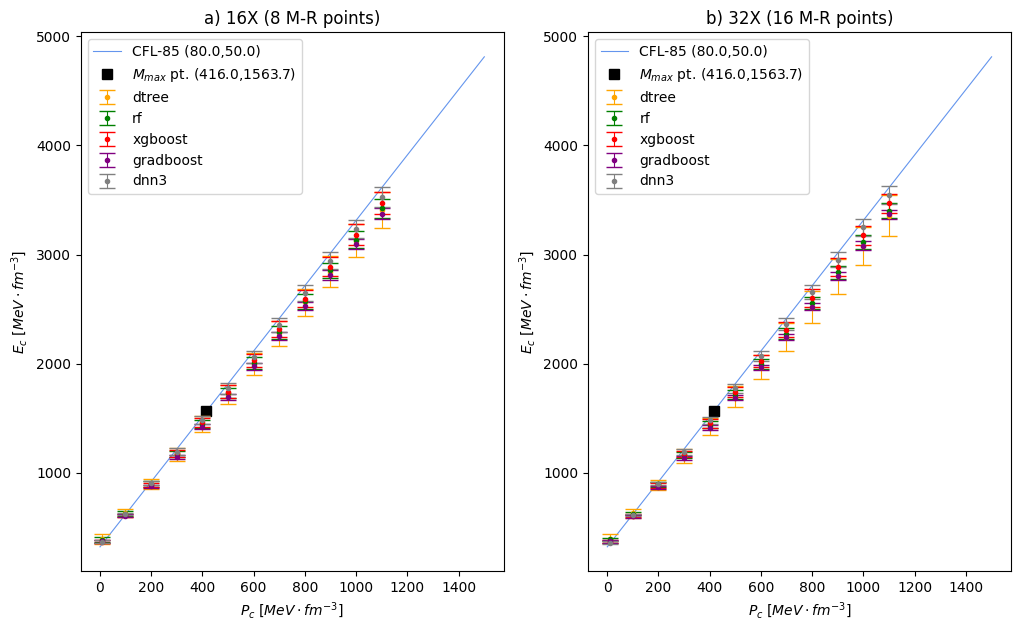

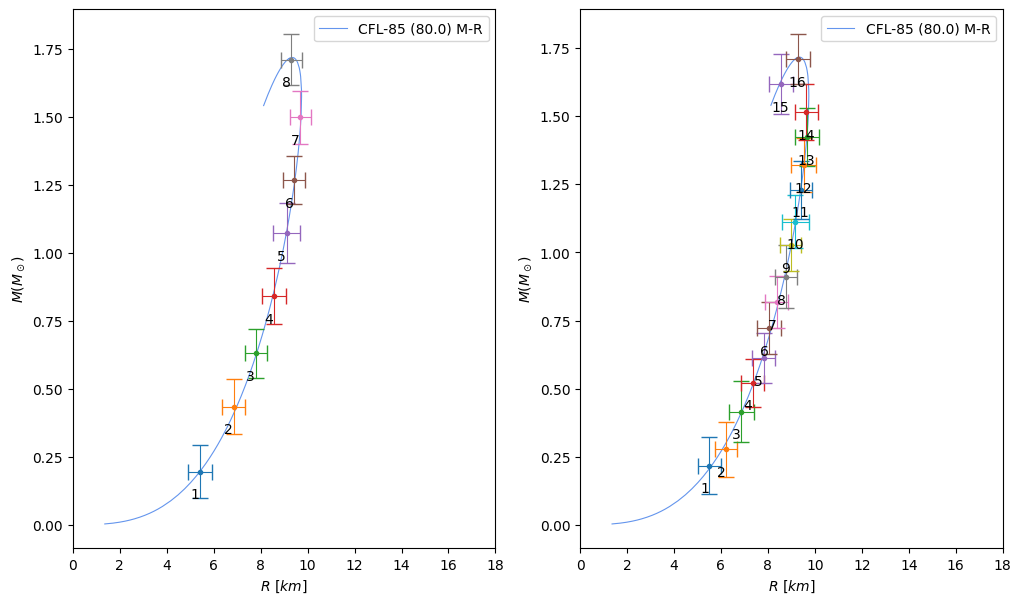

In [18]:
fig_CFL85_EOS, axes_EOS = plt.subplots(1,2,figsize=(12,7))
fig_CFL85_MR, axes_MR = plt.subplots(1,2,figsize=(12,7))

# 8 M-R points
predict_EOS_cflQS(axis_EOS=axes_EOS[0],axis_MR=axes_MR[0],cfl_EOS="CFL-85",include_Mmax=True,reg_models_infos=models_16X_infos,points_MR=8,Pc_points=Pc_pts,iterations=100)
# 16 M-R points
predict_EOS_cflQS(axis_EOS=axes_EOS[1],axis_MR=axes_MR[1],cfl_EOS="CFL-85",include_Mmax=True,reg_models_infos=models_32X_infos,points_MR=16,Pc_points=Pc_pts,iterations=100)

axes_EOS[0].set_title("a) 16X (8 M-R points)")
axes_EOS[1].set_title("b) 32X (16 M-R points)")

## **3.5 CFL-162 ($B=95$ $MeV\cdot fm^{-3}$, $Δ=190$ $MeV$) results**

> CFL-162

>> POINTS M-R: 8
---------------------------------------------------------------------
Regression models and MSLE:
dtree:  0.005885241631980583
rf:  0.0015216097335277368
xgboost:  0.0011966170935064392
gradboost:  0.0011035890126877678
dnn3:  0.001858928277061739
---------------------------------------------------------------------
Best model:
gradboost
Best model MSLE:
0.0011035890126877678
---------------------------------------------------------------------


> CFL-162

>> POINTS M-R: 16
---------------------------------------------------------------------
Regression models and MSLE:
dtree:  0.006727251511488192
rf:  0.001081224823347416
xgboost:  0.0010691817699391762
gradboost:  0.0007814777479083387
dnn3:  0.0017605027918793736
---------------------------------------------------------------------
Best model:
gradboost
Best model MSLE:
0.0007814777479083387
---------------------------------------------------------------------




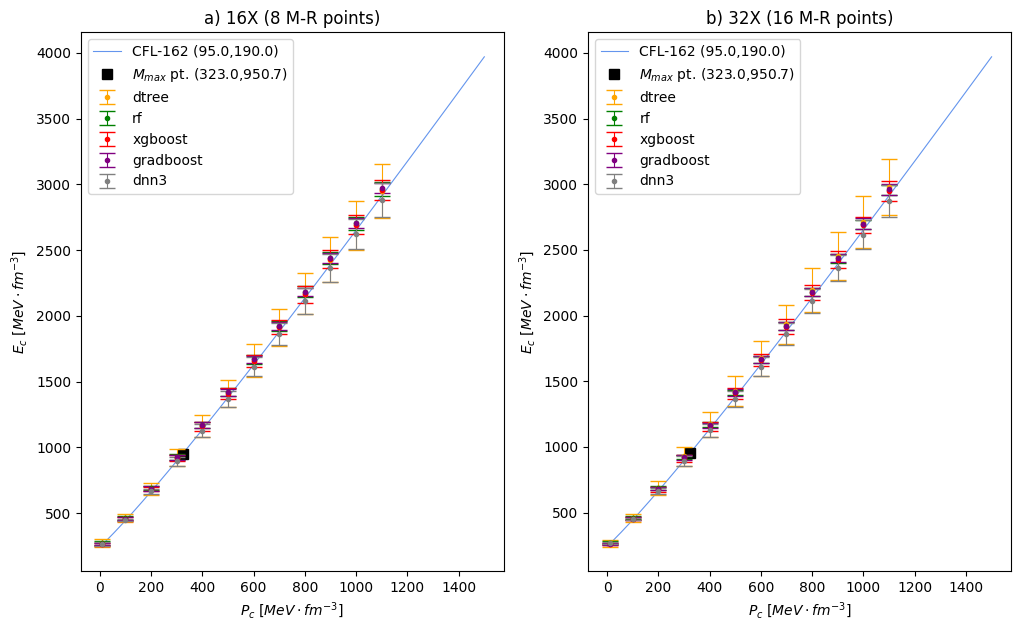

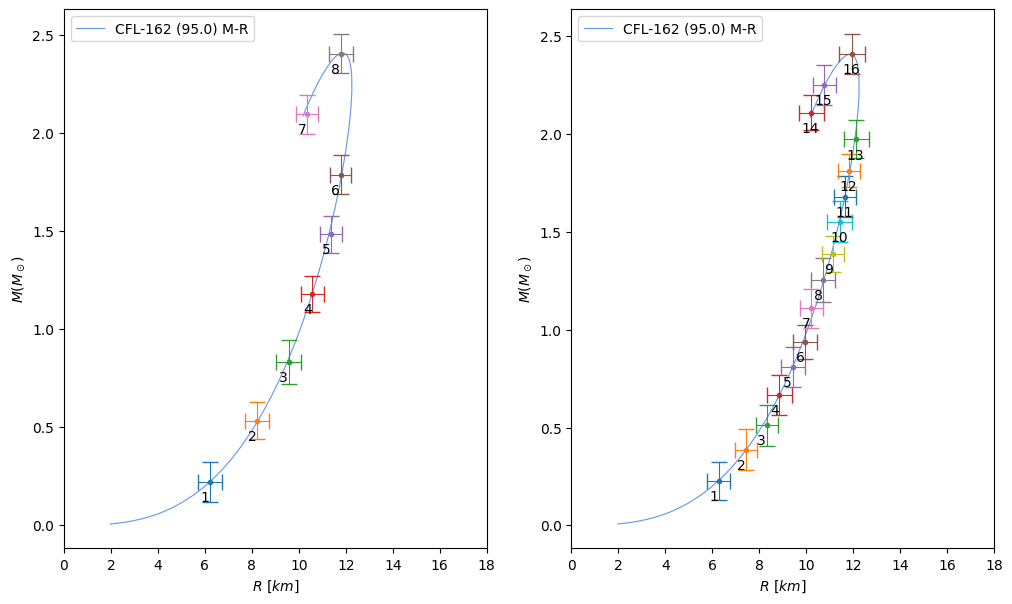

In [11]:
fig_CFL162_EOS, axes_EOS = plt.subplots(1,2,figsize=(12,7))
fig_CFL162_MR, axes_MR = plt.subplots(1,2,figsize=(12,7))

# 8 M-R points
predict_EOS_cflQS(axis_EOS=axes_EOS[0],axis_MR=axes_MR[0],cfl_EOS="CFL-162",include_Mmax=True,reg_models_infos=models_16X_infos,points_MR=8,Pc_points=Pc_pts,iterations=100)
# 16 M-R points
predict_EOS_cflQS(axis_EOS=axes_EOS[1],axis_MR=axes_MR[1],cfl_EOS="CFL-162",include_Mmax=True,reg_models_infos=models_32X_infos,points_MR=16,Pc_points=Pc_pts,iterations=100)

axes_EOS[0].set_title("a) 16X (8 M-R points)")
axes_EOS[1].set_title("b) 32X (16 M-R points)")

fig_CFL162_EOS.savefig("CFL-162_EOS_predict.png",dpi=300)

## **3.6 CFL-226 ($B=115$ $MeV\cdot fm^{-3}$, $Δ=90$ $MeV$) results**

> CFL-226

>> POINTS M-R: 8
---------------------------------------------------------------------
Regression models and MSLE:
dtree:  0.003996769758473294
rf:  0.0017512809595736686
xgboost:  0.0018853368934385144
gradboost:  0.0024199746349385007
dnn3:  0.0013884689342945553
---------------------------------------------------------------------
Best model:
dnn3
Best model MSLE:
0.0013884689342945553
---------------------------------------------------------------------


> CFL-226

>> POINTS M-R: 16
---------------------------------------------------------------------
Regression models and MSLE:
dtree:  0.0050262676346342
rf:  0.002186322364834867
xgboost:  0.002056909508714342
gradboost:  0.0025518895585034344
dnn3:  0.0018359768859431656
---------------------------------------------------------------------
Best model:
dnn3
Best model MSLE:
0.0018359768859431656
---------------------------------------------------------------------




Text(0.5, 1.0, 'b) 32X (16 M-R points)')

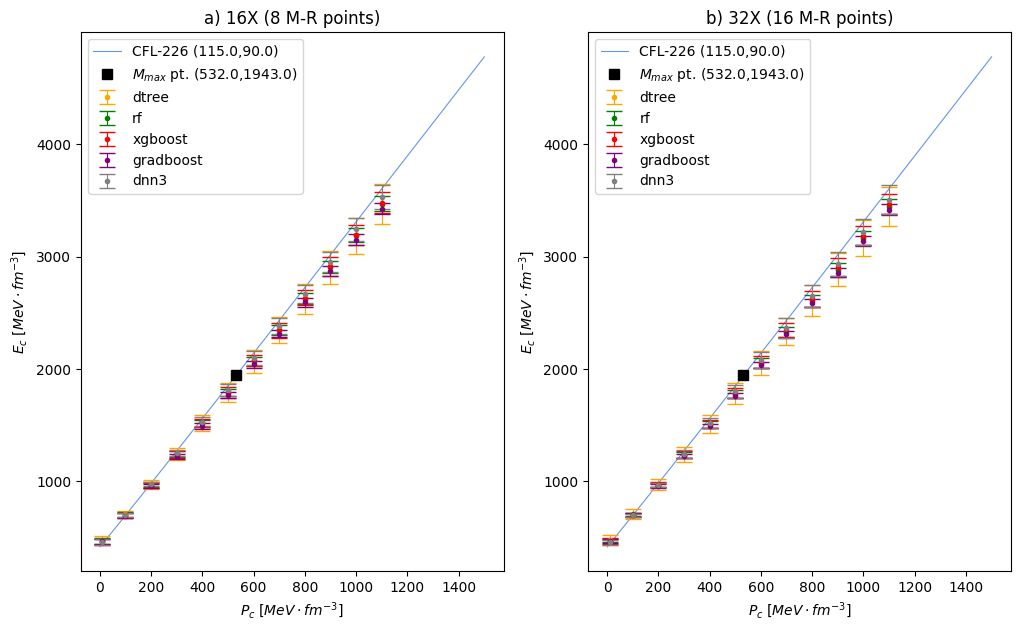

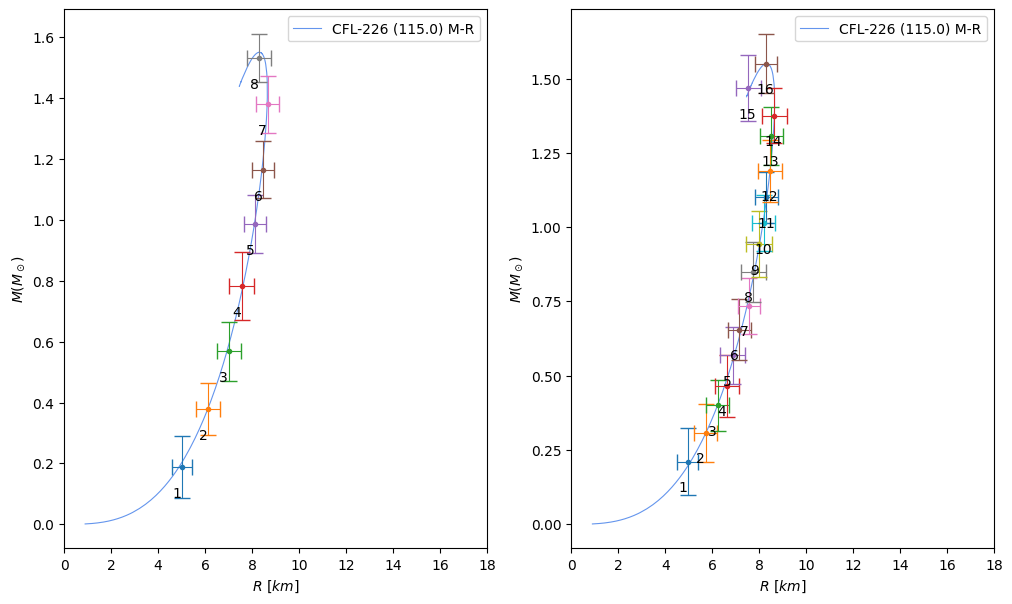

In [20]:
fig_CFL226_EOS, axes_EOS = plt.subplots(1,2,figsize=(12,7))
fig_CFL226_MR, axes_MR = plt.subplots(1,2,figsize=(12,7))

# 8 M-R points
predict_EOS_cflQS(axis_EOS=axes_EOS[0],axis_MR=axes_MR[0],cfl_EOS="CFL-226",include_Mmax=True,reg_models_infos=models_16X_infos,points_MR=8,Pc_points=Pc_pts,iterations=100)
# 16 M-R points
predict_EOS_cflQS(axis_EOS=axes_EOS[1],axis_MR=axes_MR[1],cfl_EOS="CFL-226",include_Mmax=True,reg_models_infos=models_32X_infos,points_MR=16,Pc_points=Pc_pts,iterations=100)

axes_EOS[0].set_title("a) 16X (8 M-R points)")
axes_EOS[1].set_title("b) 32X (16 M-R points)")

## **3.7 CFL-255 ($B=120$ $MeV\cdot fm^{-3}$, $Δ=220$ $MeV$) results**

> CFL-255

>> POINTS M-R: 8
---------------------------------------------------------------------
Regression models and MSLE:
dtree:  0.008156902480116924
rf:  0.004445800270743212
xgboost:  0.0033791416182223136
gradboost:  0.0062993360062662505
dnn3:  0.002803169696076421
---------------------------------------------------------------------
Best model:
dnn3
Best model MSLE:
0.002803169696076421
---------------------------------------------------------------------


> CFL-255

>> POINTS M-R: 16
---------------------------------------------------------------------
Regression models and MSLE:
dtree:  0.010117370520404702
rf:  0.005408561899426831
xgboost:  0.0037663898718426486
gradboost:  0.006942031590734495
dnn3:  0.001162089725075971
---------------------------------------------------------------------
Best model:
dnn3
Best model MSLE:
0.001162089725075971
---------------------------------------------------------------------




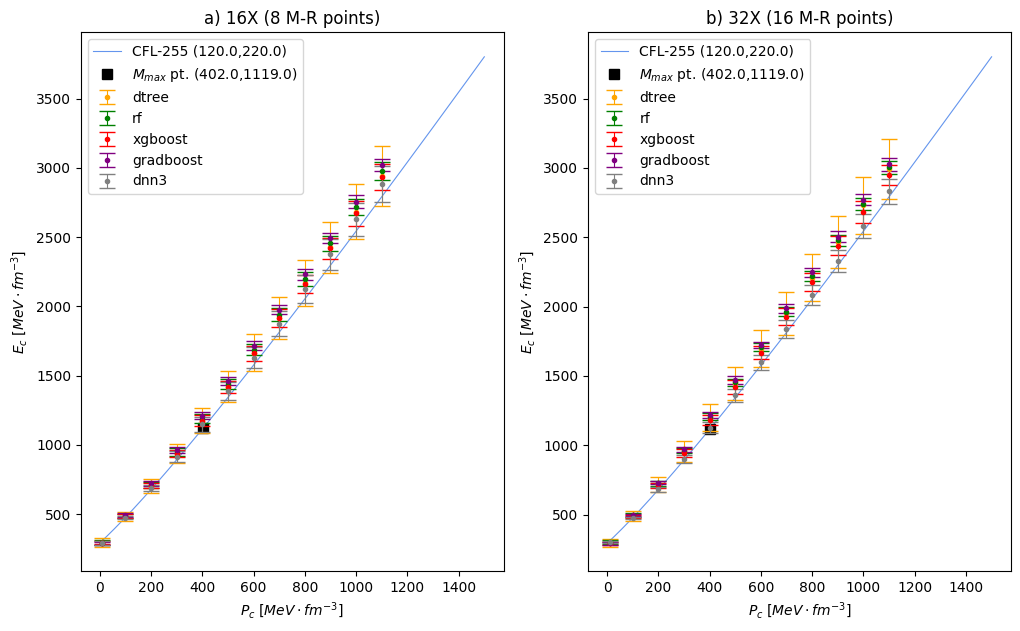

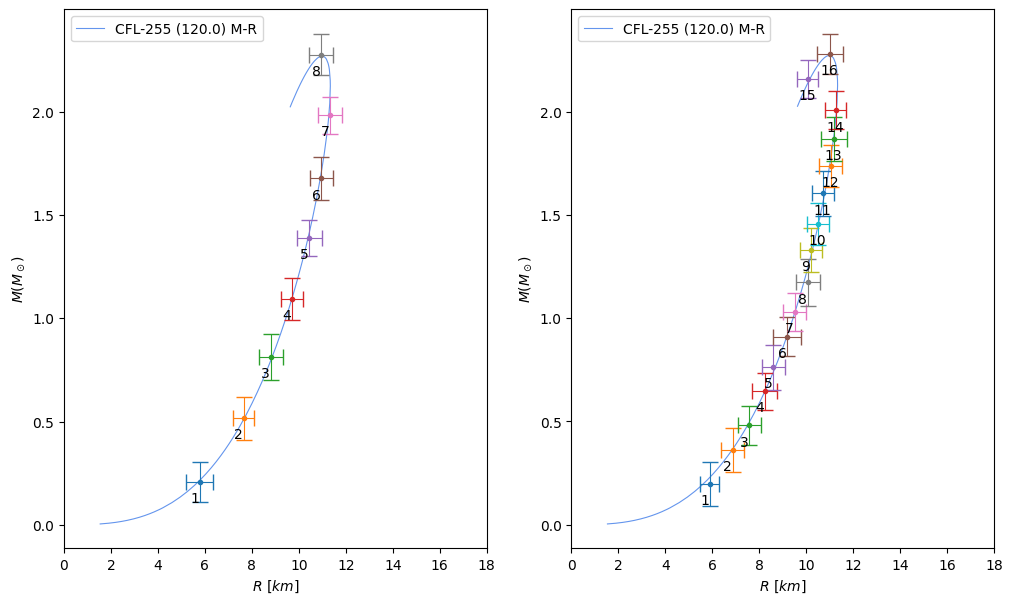

In [12]:
fig_CFL255_EOS, axes_EOS = plt.subplots(1,2,figsize=(12,7))
fig_CFL255_MR, axes_MR = plt.subplots(1,2,figsize=(12,7))

# 8 M-R points
predict_EOS_cflQS(axis_EOS=axes_EOS[0],axis_MR=axes_MR[0],cfl_EOS="CFL-255",include_Mmax=True,reg_models_infos=models_16X_infos,points_MR=8,Pc_points=Pc_pts,iterations=100)
# 16 M-R points
predict_EOS_cflQS(axis_EOS=axes_EOS[1],axis_MR=axes_MR[1],cfl_EOS="CFL-255",include_Mmax=True,reg_models_infos=models_32X_infos,points_MR=16,Pc_points=Pc_pts,iterations=100)

axes_EOS[0].set_title("a) 16X (8 M-R points)")
axes_EOS[1].set_title("b) 32X (16 M-R points)")

fig_CFL255_EOS.savefig("CFL-255_EOS_predict.png",dpi=300)

## **3.8 CFL-363 ($B=160$ $MeV\cdot fm^{-3}$, $Δ=210$ $MeV$) results**

> CFL-363

>> POINTS M-R: 8
---------------------------------------------------------------------
Regression models and MSLE:
dtree:  0.009340443560971001
rf:  0.005488935853606467
xgboost:  0.004451196727771111
gradboost:  0.006958804019931086
dnn3:  0.002855519147254775
---------------------------------------------------------------------
Best model:
dnn3
Best model MSLE:
0.002855519147254775
---------------------------------------------------------------------


> CFL-363

>> POINTS M-R: 16
---------------------------------------------------------------------
Regression models and MSLE:
dtree:  0.01013879336163175
rf:  0.0053020724174472865
xgboost:  0.003914717503317449
gradboost:  0.0068868365921887055
dnn3:  0.0014699875223613448
---------------------------------------------------------------------
Best model:
dnn3
Best model MSLE:
0.0014699875223613448
---------------------------------------------------------------------




Text(0.5, 1.0, 'b) 32X (16 M-R points)')

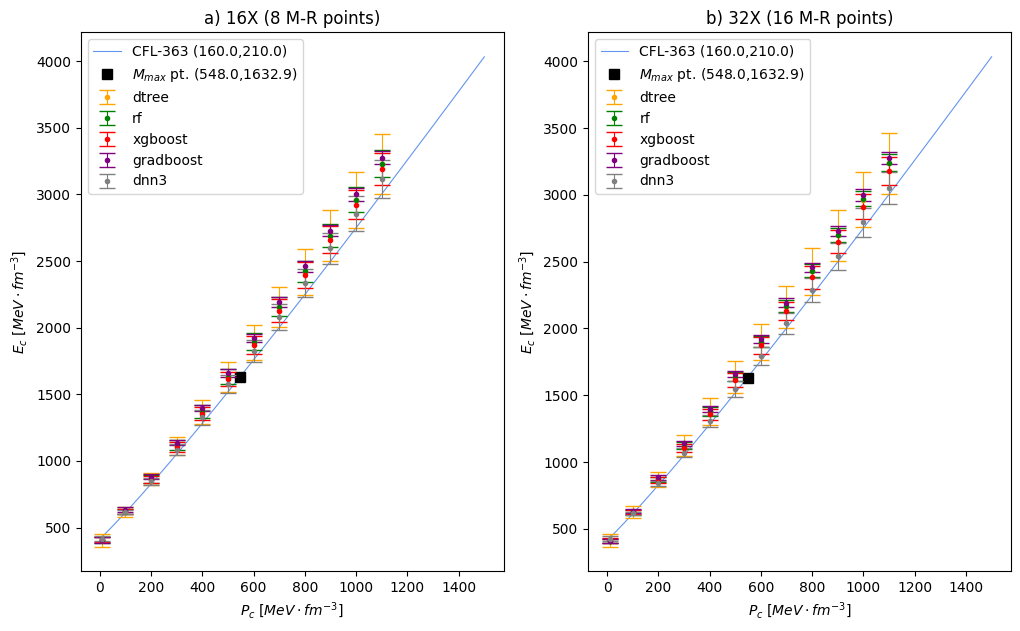

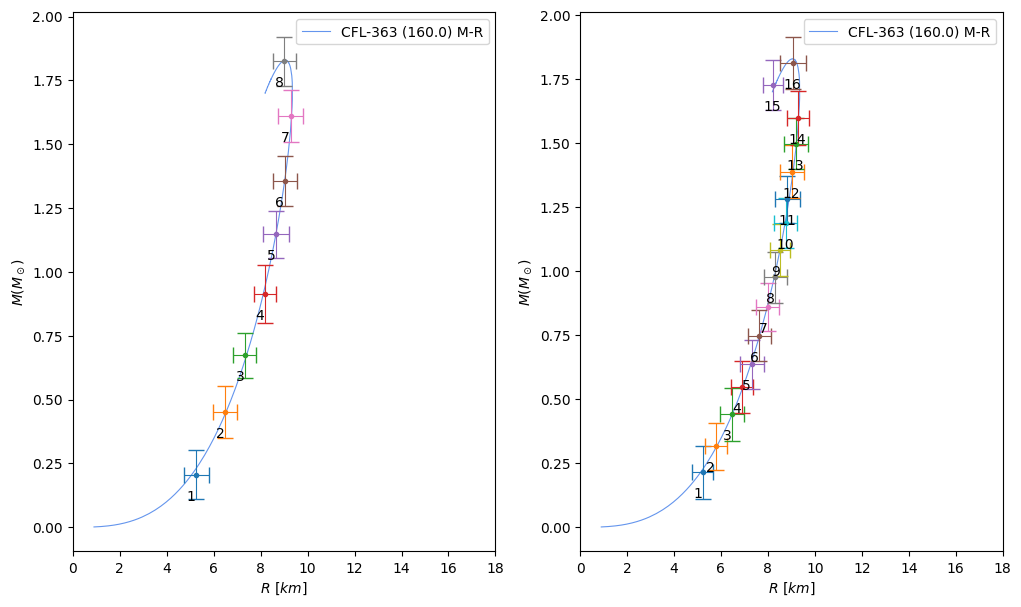

In [22]:
fig_CFL363_EOS, axes_EOS = plt.subplots(1,2,figsize=(12,7))
fig_CFL363_MR, axes_MR = plt.subplots(1,2,figsize=(12,7))

# 8 M-R points
predict_EOS_cflQS(axis_EOS=axes_EOS[0],axis_MR=axes_MR[0],cfl_EOS="CFL-363",include_Mmax=True,reg_models_infos=models_16X_infos,points_MR=8,Pc_points=Pc_pts,iterations=100)
# 16 M-R points
predict_EOS_cflQS(axis_EOS=axes_EOS[1],axis_MR=axes_MR[1],cfl_EOS="CFL-363",include_Mmax=True,reg_models_infos=models_32X_infos,points_MR=16,Pc_points=Pc_pts,iterations=100)

axes_EOS[0].set_title("a) 16X (8 M-R points)")
axes_EOS[1].set_title("b) 32X (16 M-R points)")

## **3.9 CFL-418 ($B=185$ $MeV\cdot fm^{-3}$, $Δ=240$ $MeV$) results**

> CFL-418

>> POINTS M-R: 8
---------------------------------------------------------------------
Regression models and MSLE:
dtree:  0.01334677052731946
rf:  0.010671493405926179
xgboost:  0.007432046874889655
gradboost:  0.013405158263033472
dnn3:  0.006167997586294583
---------------------------------------------------------------------
Best model:
dnn3
Best model MSLE:
0.006167997586294583
---------------------------------------------------------------------


> CFL-418

>> POINTS M-R: 16
---------------------------------------------------------------------
Regression models and MSLE:
dtree:  0.01758131592723874
rf:  0.010376448766214408
xgboost:  0.006020124258116878
gradboost:  0.01279146802200283
dnn3:  0.0029034936783940454
---------------------------------------------------------------------
Best model:
dnn3
Best model MSLE:
0.0029034936783940454
---------------------------------------------------------------------




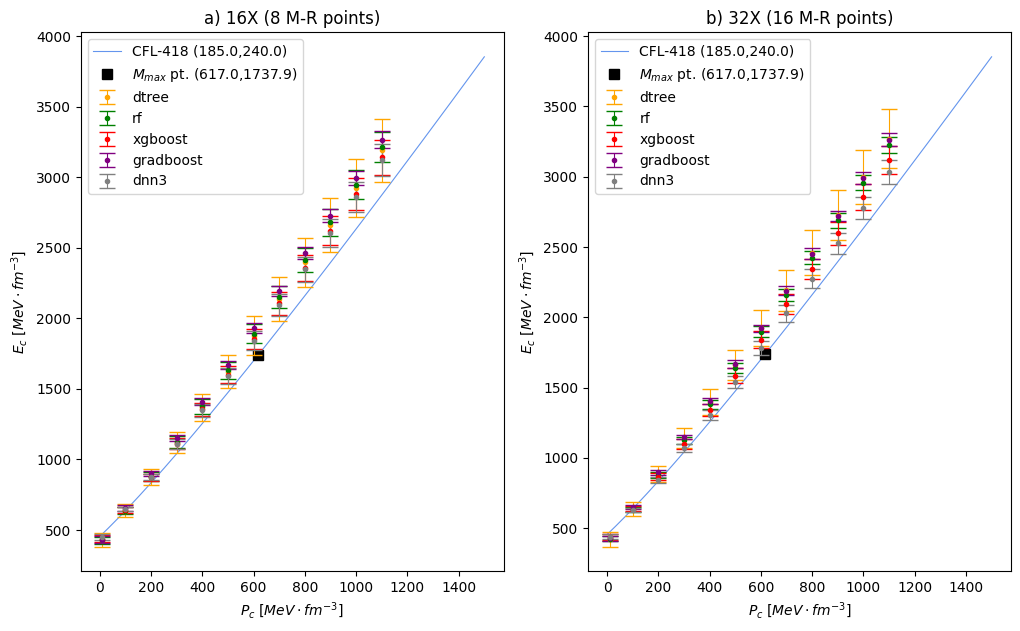

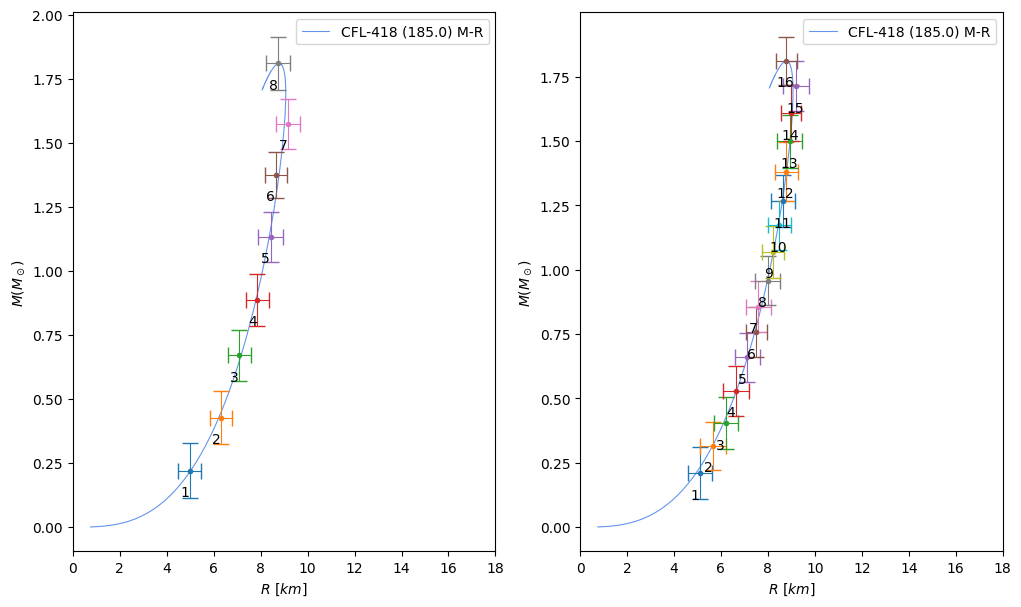

In [13]:
fig_CFL418_EOS, axes_EOS = plt.subplots(1,2,figsize=(12,7))
fig_CFL418_MR, axes_MR = plt.subplots(1,2,figsize=(12,7))

# 8 M-R points
predict_EOS_cflQS(axis_EOS=axes_EOS[0],axis_MR=axes_MR[0],cfl_EOS="CFL-418",include_Mmax=True,reg_models_infos=models_16X_infos,points_MR=8,Pc_points=Pc_pts,iterations=100)
# 16 M-R points
predict_EOS_cflQS(axis_EOS=axes_EOS[1],axis_MR=axes_MR[1],cfl_EOS="CFL-418",include_Mmax=True,reg_models_infos=models_32X_infos,points_MR=16,Pc_points=Pc_pts,iterations=100)

axes_EOS[0].set_title("a) 16X (8 M-R points)")
axes_EOS[1].set_title("b) 32X (16 M-R points)")

fig_CFL418_EOS.savefig("CFL-418_EOS_predict.png",dpi=300)

## **3.10 CFL-469 ($B=220$ $MeV\cdot fm^{-3}$, $Δ=190$ $MeV$) results**

> CFL-469

>> POINTS M-R: 8
---------------------------------------------------------------------
Regression models and MSLE:
dtree:  0.007703164188827144
rf:  0.005078139603290718
xgboost:  0.0035195335054701744
gradboost:  0.004614638498628612
dnn3:  0.0024515601499987536
---------------------------------------------------------------------
Best model:
dnn3
Best model MSLE:
0.0024515601499987536
---------------------------------------------------------------------


> CFL-469

>> POINTS M-R: 16
---------------------------------------------------------------------
Regression models and MSLE:
dtree:  0.01013344897373143
rf:  0.0044937242650439965
xgboost:  0.0032767090303390256
gradboost:  0.004482130950524612
dnn3:  0.0017533039281903736
---------------------------------------------------------------------
Best model:
dnn3
Best model MSLE:
0.0017533039281903736
---------------------------------------------------------------------




Text(0.5, 1.0, 'b) 32X (16 M-R points)')

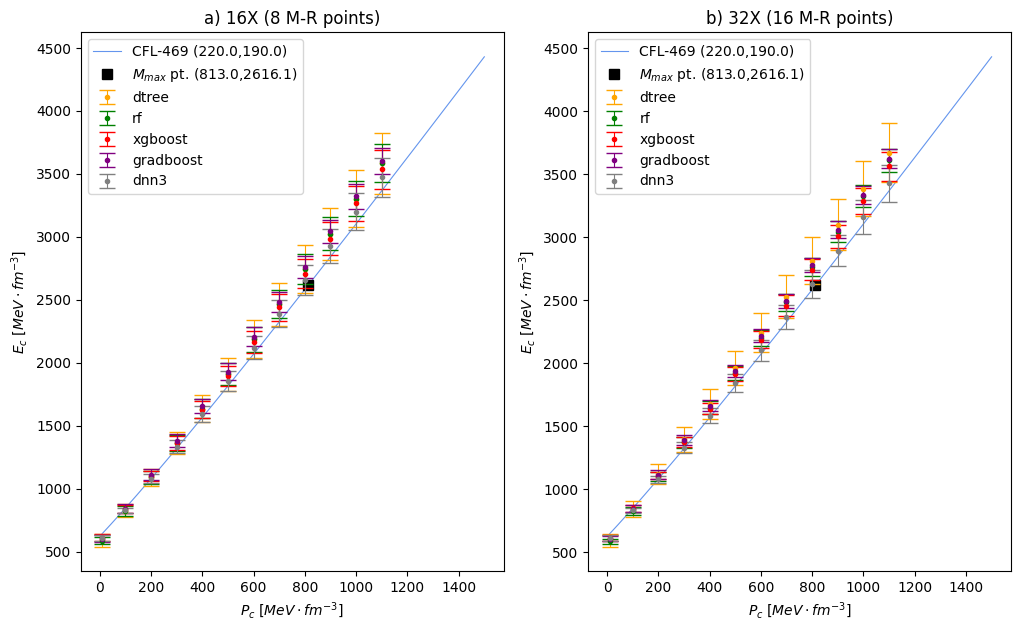

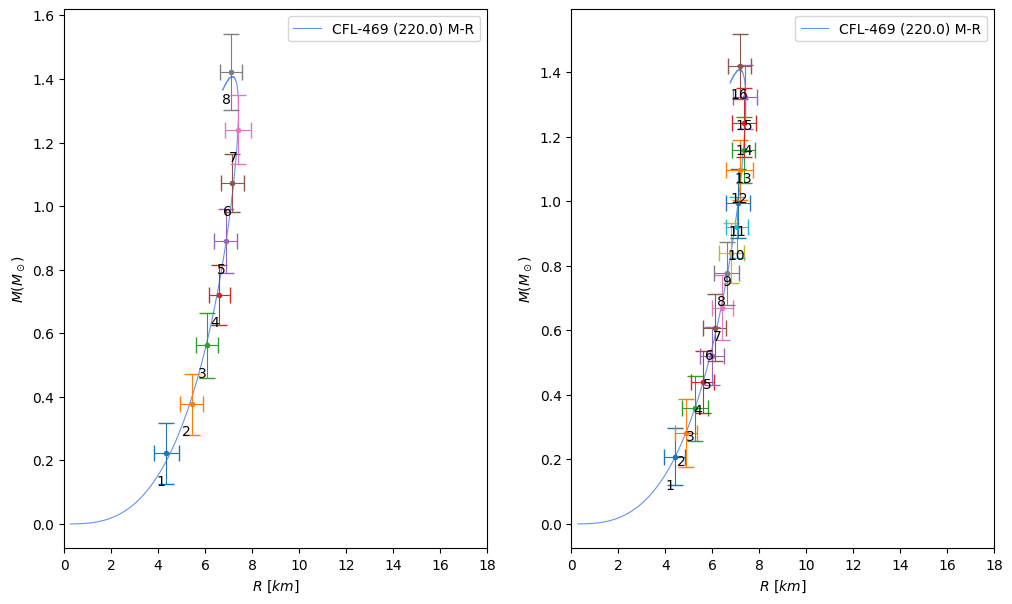

In [24]:
fig_CFL469_EOS, axes_EOS = plt.subplots(1,2,figsize=(12,7))
fig_CFL469_MR, axes_MR = plt.subplots(1,2,figsize=(12,7))

# 8 M-R points
predict_EOS_cflQS(axis_EOS=axes_EOS[0],axis_MR=axes_MR[0],cfl_EOS="CFL-469",include_Mmax=True,reg_models_infos=models_16X_infos,points_MR=8,Pc_points=Pc_pts,iterations=100)
# 16 M-R points
predict_EOS_cflQS(axis_EOS=axes_EOS[1],axis_MR=axes_MR[1],cfl_EOS="CFL-469",include_Mmax=True,reg_models_infos=models_32X_infos,points_MR=16,Pc_points=Pc_pts,iterations=100)

axes_EOS[0].set_title("a) 16X (8 M-R points)")
axes_EOS[1].set_title("b) 32X (16 M-R points)")